In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [2]:
import numpy as np
import hgpflow_v2.performance # don't know why this is needed, but it is
from hgpflow_v2.performance.performance import PerformanceCOCOA
from copy import deepcopy

In [3]:
IND_THRESHOLD = 0.50

In [4]:
save_dir = '...'
SAVE_FIG = False

# Dijet

In [ ]:
pred_path = 'path to HGPflow dijet prediction.root'
truth_path = 'path to dijet test.root'
mlpf_path = 'path to MLPF dijet prediction.root'
perf_obj_mini = PerformanceCOCOA(truth_path, pred_path, ind_threshold=IND_THRESHOLD, topo=False, pred_path_mlpf=mlpf_path)

### Overwrite

- `hgpflow_pt` for neutral particles is better than `proxy_pt`
- But the rest are just worse
- So, I will just overwrite the `hgpflow_xxx` with `proxy_xxx` for the rest

In [6]:
perf_obj_mini.hgpflow_dict['hgpflow_eta'] = perf_obj_mini.hgpflow_dict['proxy_eta']
perf_obj_mini.hgpflow_dict['hgpflow_phi'] = perf_obj_mini.hgpflow_dict['proxy_phi']

for i in range(len(perf_obj_mini.hgpflow_dict['hgpflow_pt'])):
    ch_mask = perf_obj_mini.hgpflow_dict['hgpflow_class'][i] <= 2
    perf_obj_mini.hgpflow_dict['hgpflow_pt'][i][ch_mask] = perf_obj_mini.hgpflow_dict['proxy_pt'][i][ch_mask]

In [ ]:
perf_obj_mini.compute_jets(n_procs=30)
perf_obj_mini.match_jets()

### Jet residual plots

In [8]:
from hgpflow_v2.performance.plot_helper_event import compute_jet_residual_dict

_dict = {
    'ppflow': perf_obj_mini.truth_dict['matched_ppflow_jets'],
    'mlpf': perf_obj_mini.mlpf_dict['matched_mlpf_jets'],
    'hgpflow': perf_obj_mini.hgpflow_dict['matched_hgpflow_jets'],
}

jet_residual_dict = compute_jet_residual_dict(_dict, dr_cut=0.1, leading_N_jets=2, pt_min=10)

#### Jet residuals

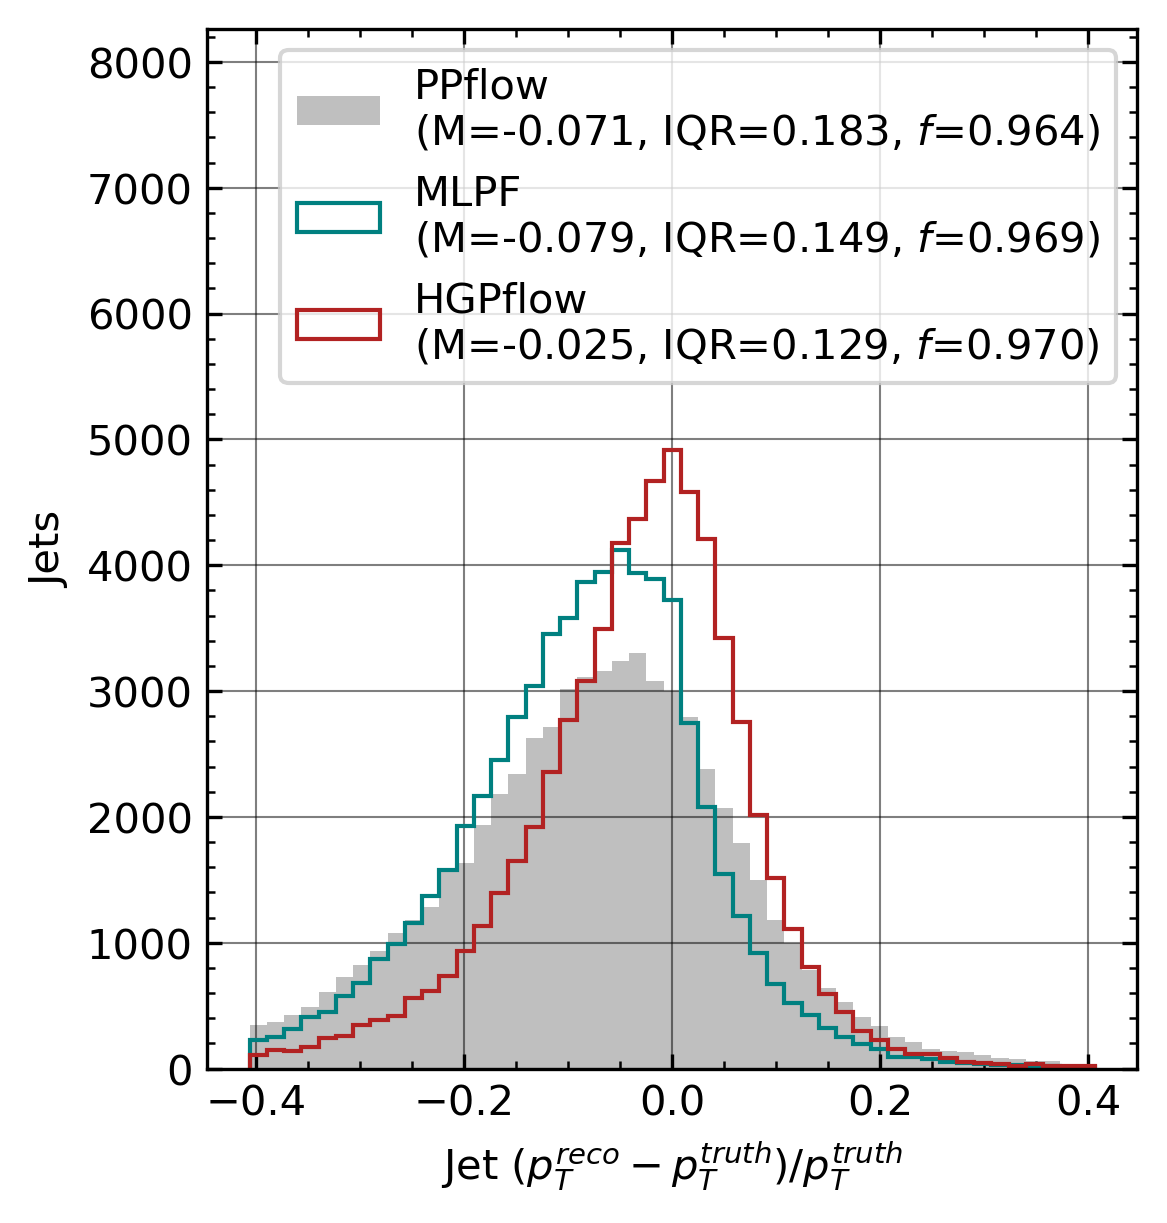

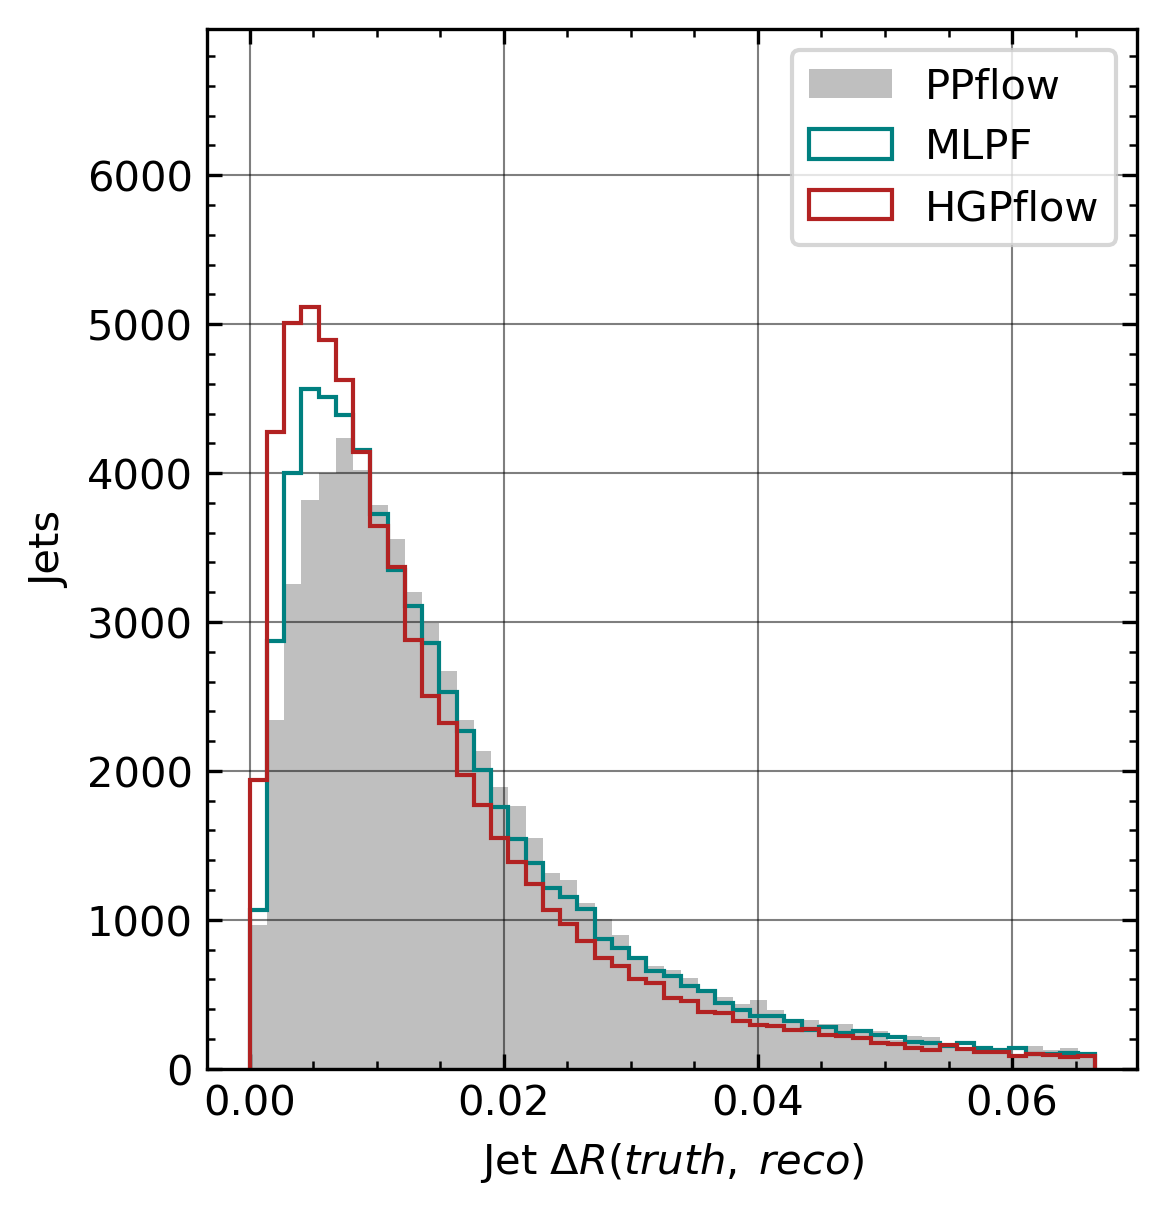

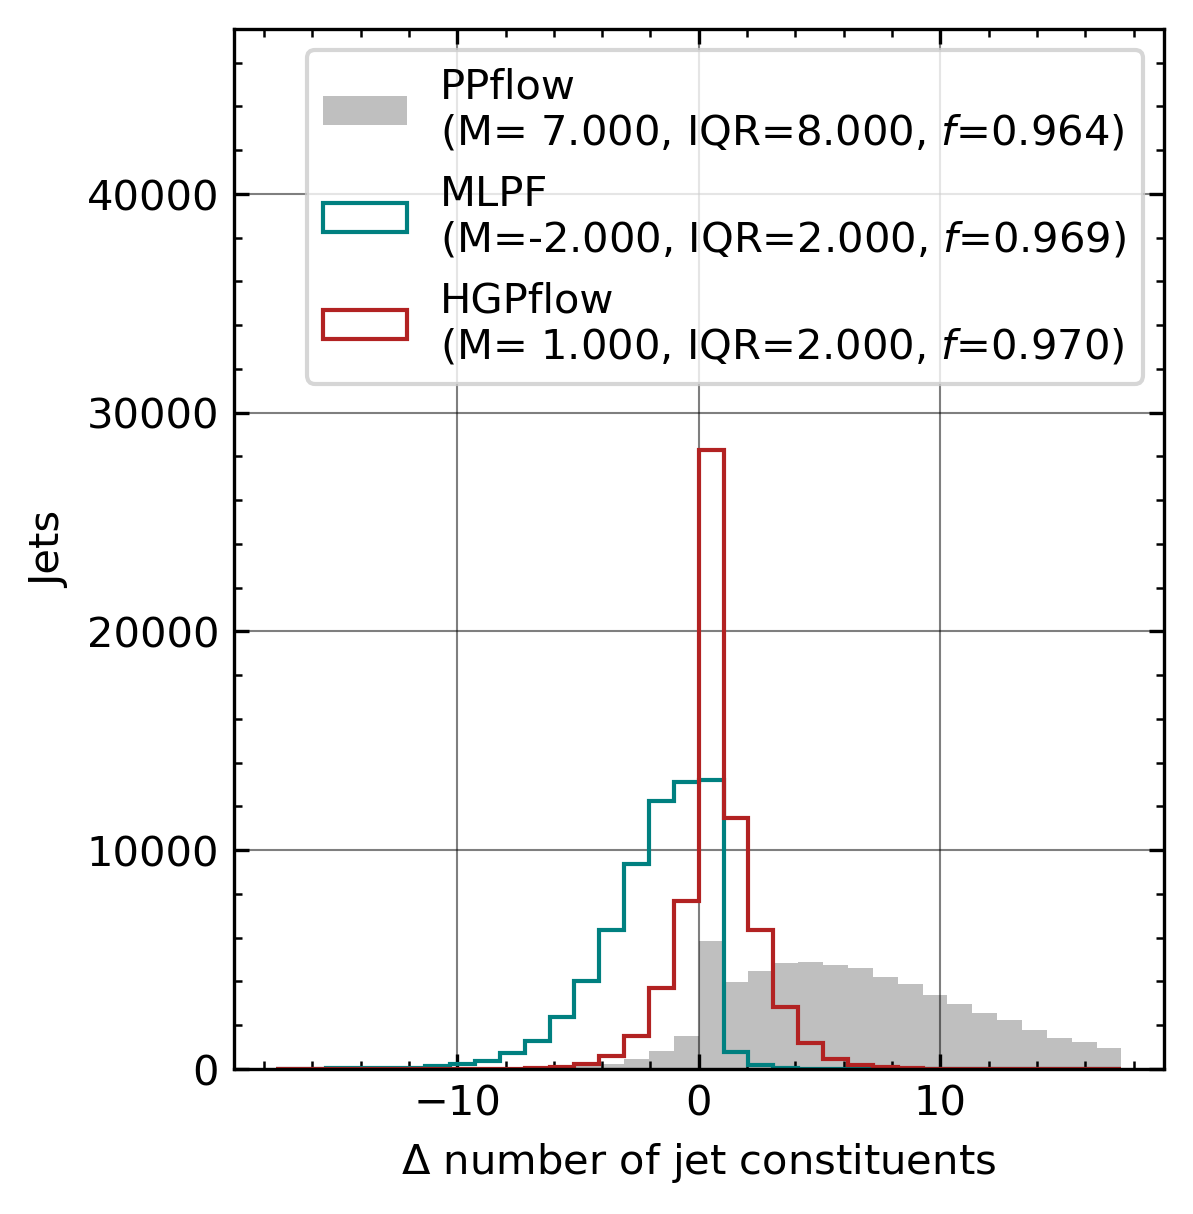

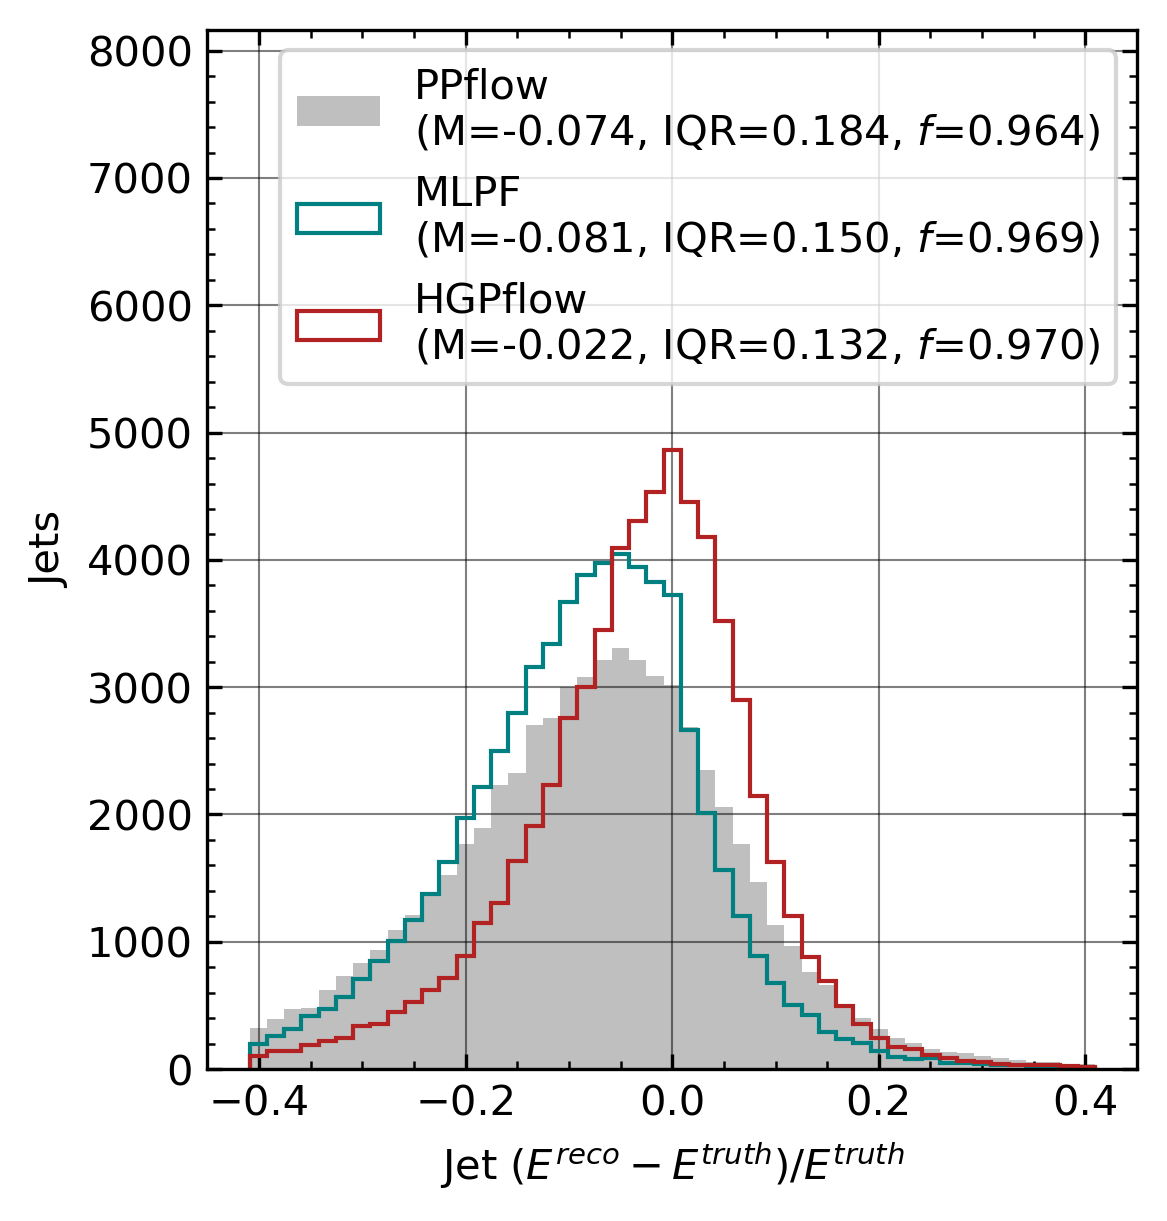

In [9]:
from hgpflow_v2.performance.plot_helper_event import plot_jet_residuals

figs = plot_jet_residuals(jet_residual_dict, pt_relative=True, separate_figures=True)
if SAVE_FIG:
    figs[0].savefig(f'{save_dir}/dijet_jet_residuals_pt.png', dpi=300)
    figs[1].savefig(f'{save_dir}/dijet_jet_residuals_dr.png', dpi=300)
    figs[2].savefig(f'{save_dir}/dijet_jet_residuals_constcount.png', dpi=300)

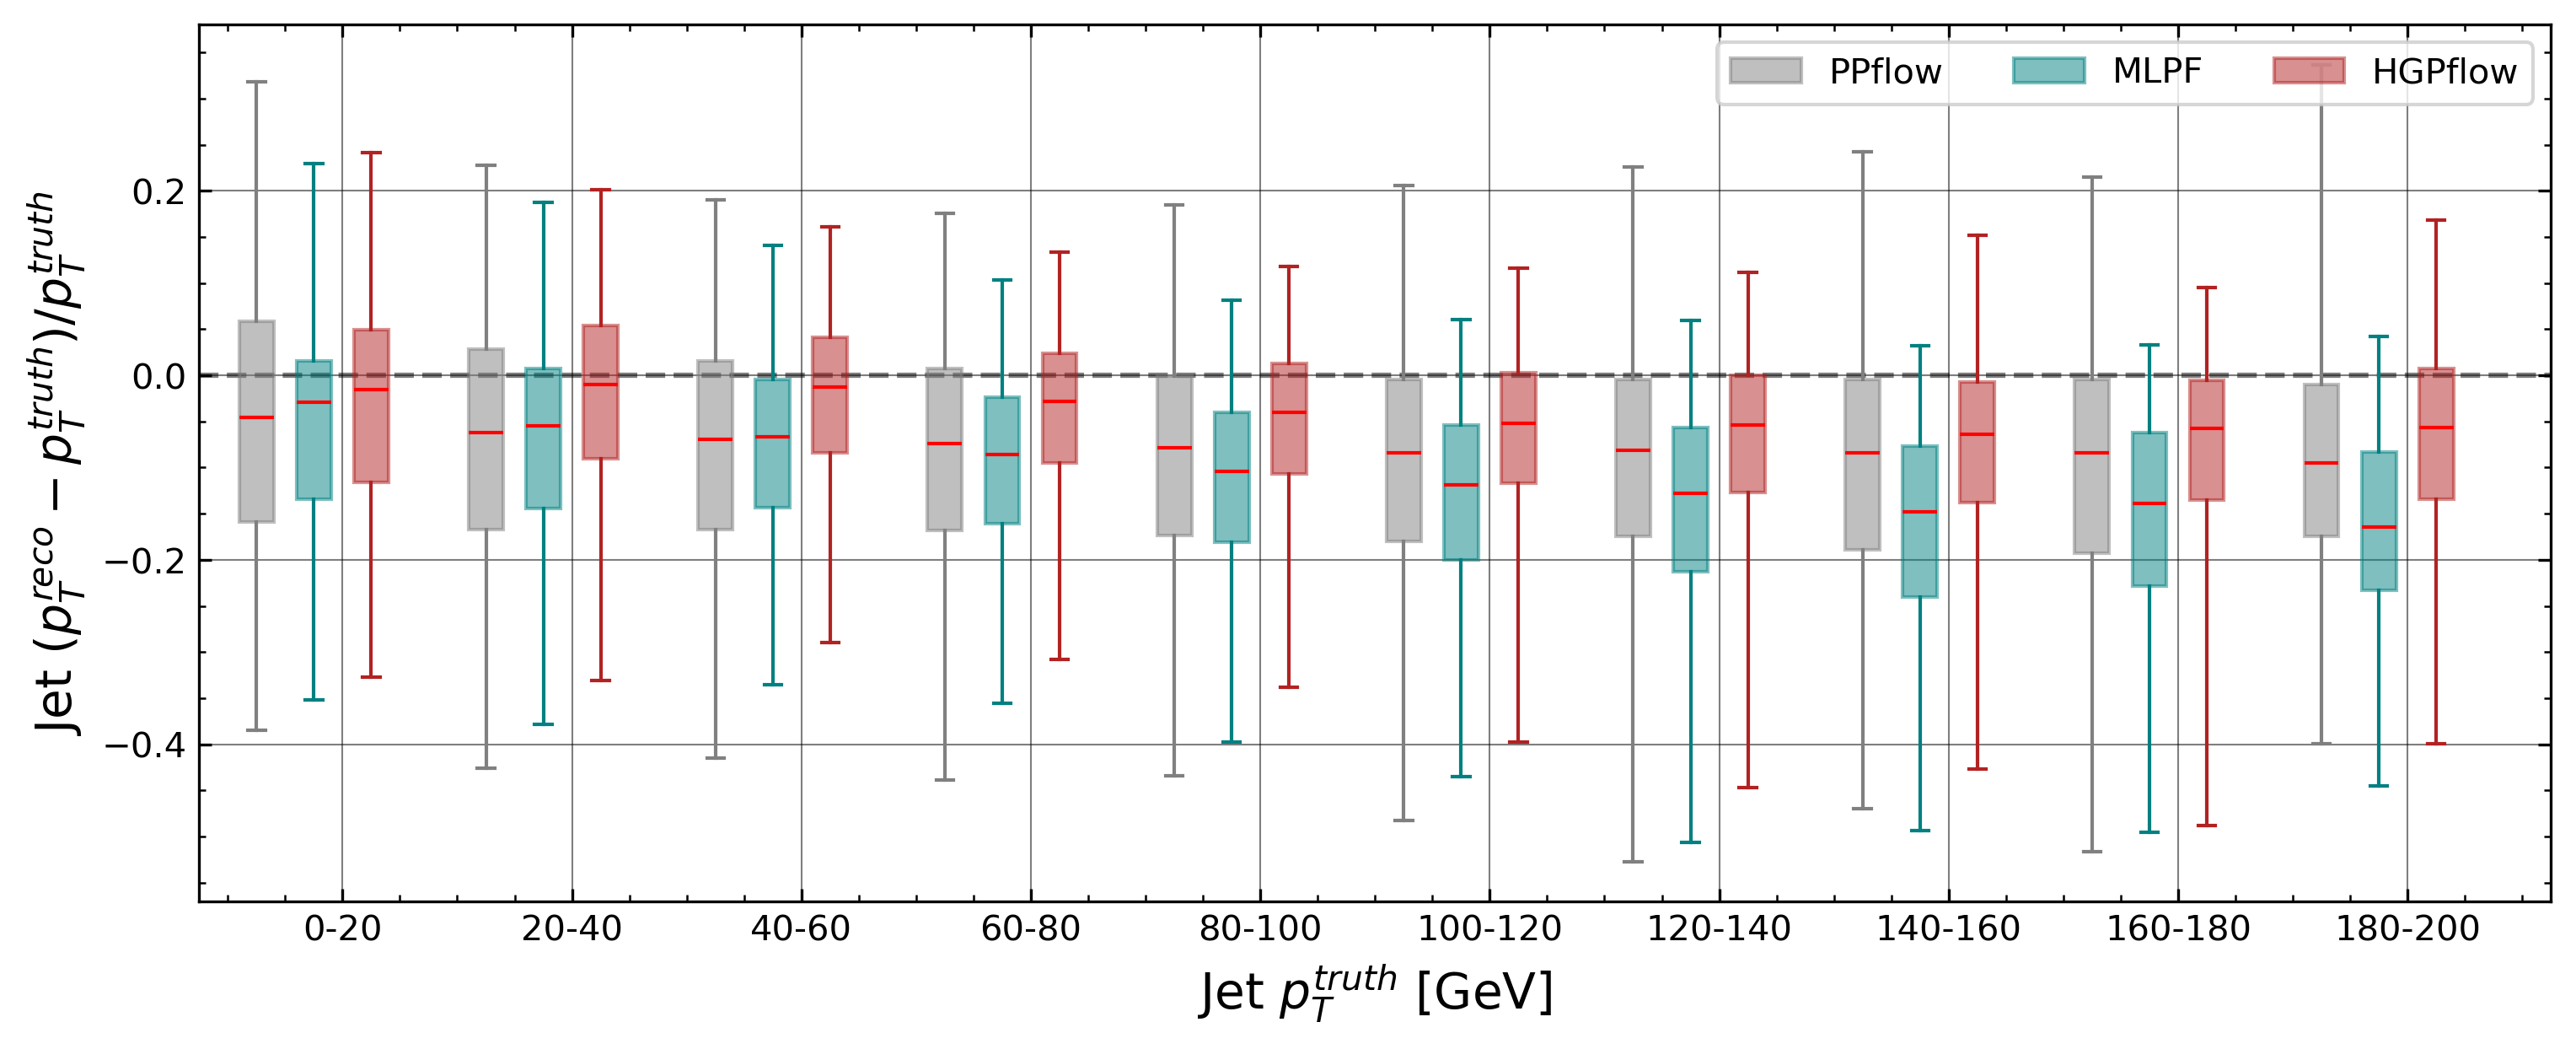

In [10]:
from hgpflow_v2.performance.plot_helper_event import plot_jet_res_boxplot

pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_res_boxplot(jet_residual_dict, bins=pt_bins)

#### Efficiency and fakerate

In [13]:
perf_obj_mini.hung_match_particles(flatten=True, return_unmatched=True)

Matching particles...: 100%|██████████| 35696/35696 [00:07<00:00, 4946.29it/s]


In [20]:
style_sheet_eff_fr = {
    'LINE_STYLES': {
        'hgpflow': '-',
        'mlpf': '--',
    },
    'COLORS': {
        'hgpflow': {
            'neut had': 'mediumseagreen',
            'photon': 'tomato',
        },
        'mlpf': {
            'neut had': 'dodgerblue',
            'photon': 'goldenrod',
        }
    }
}

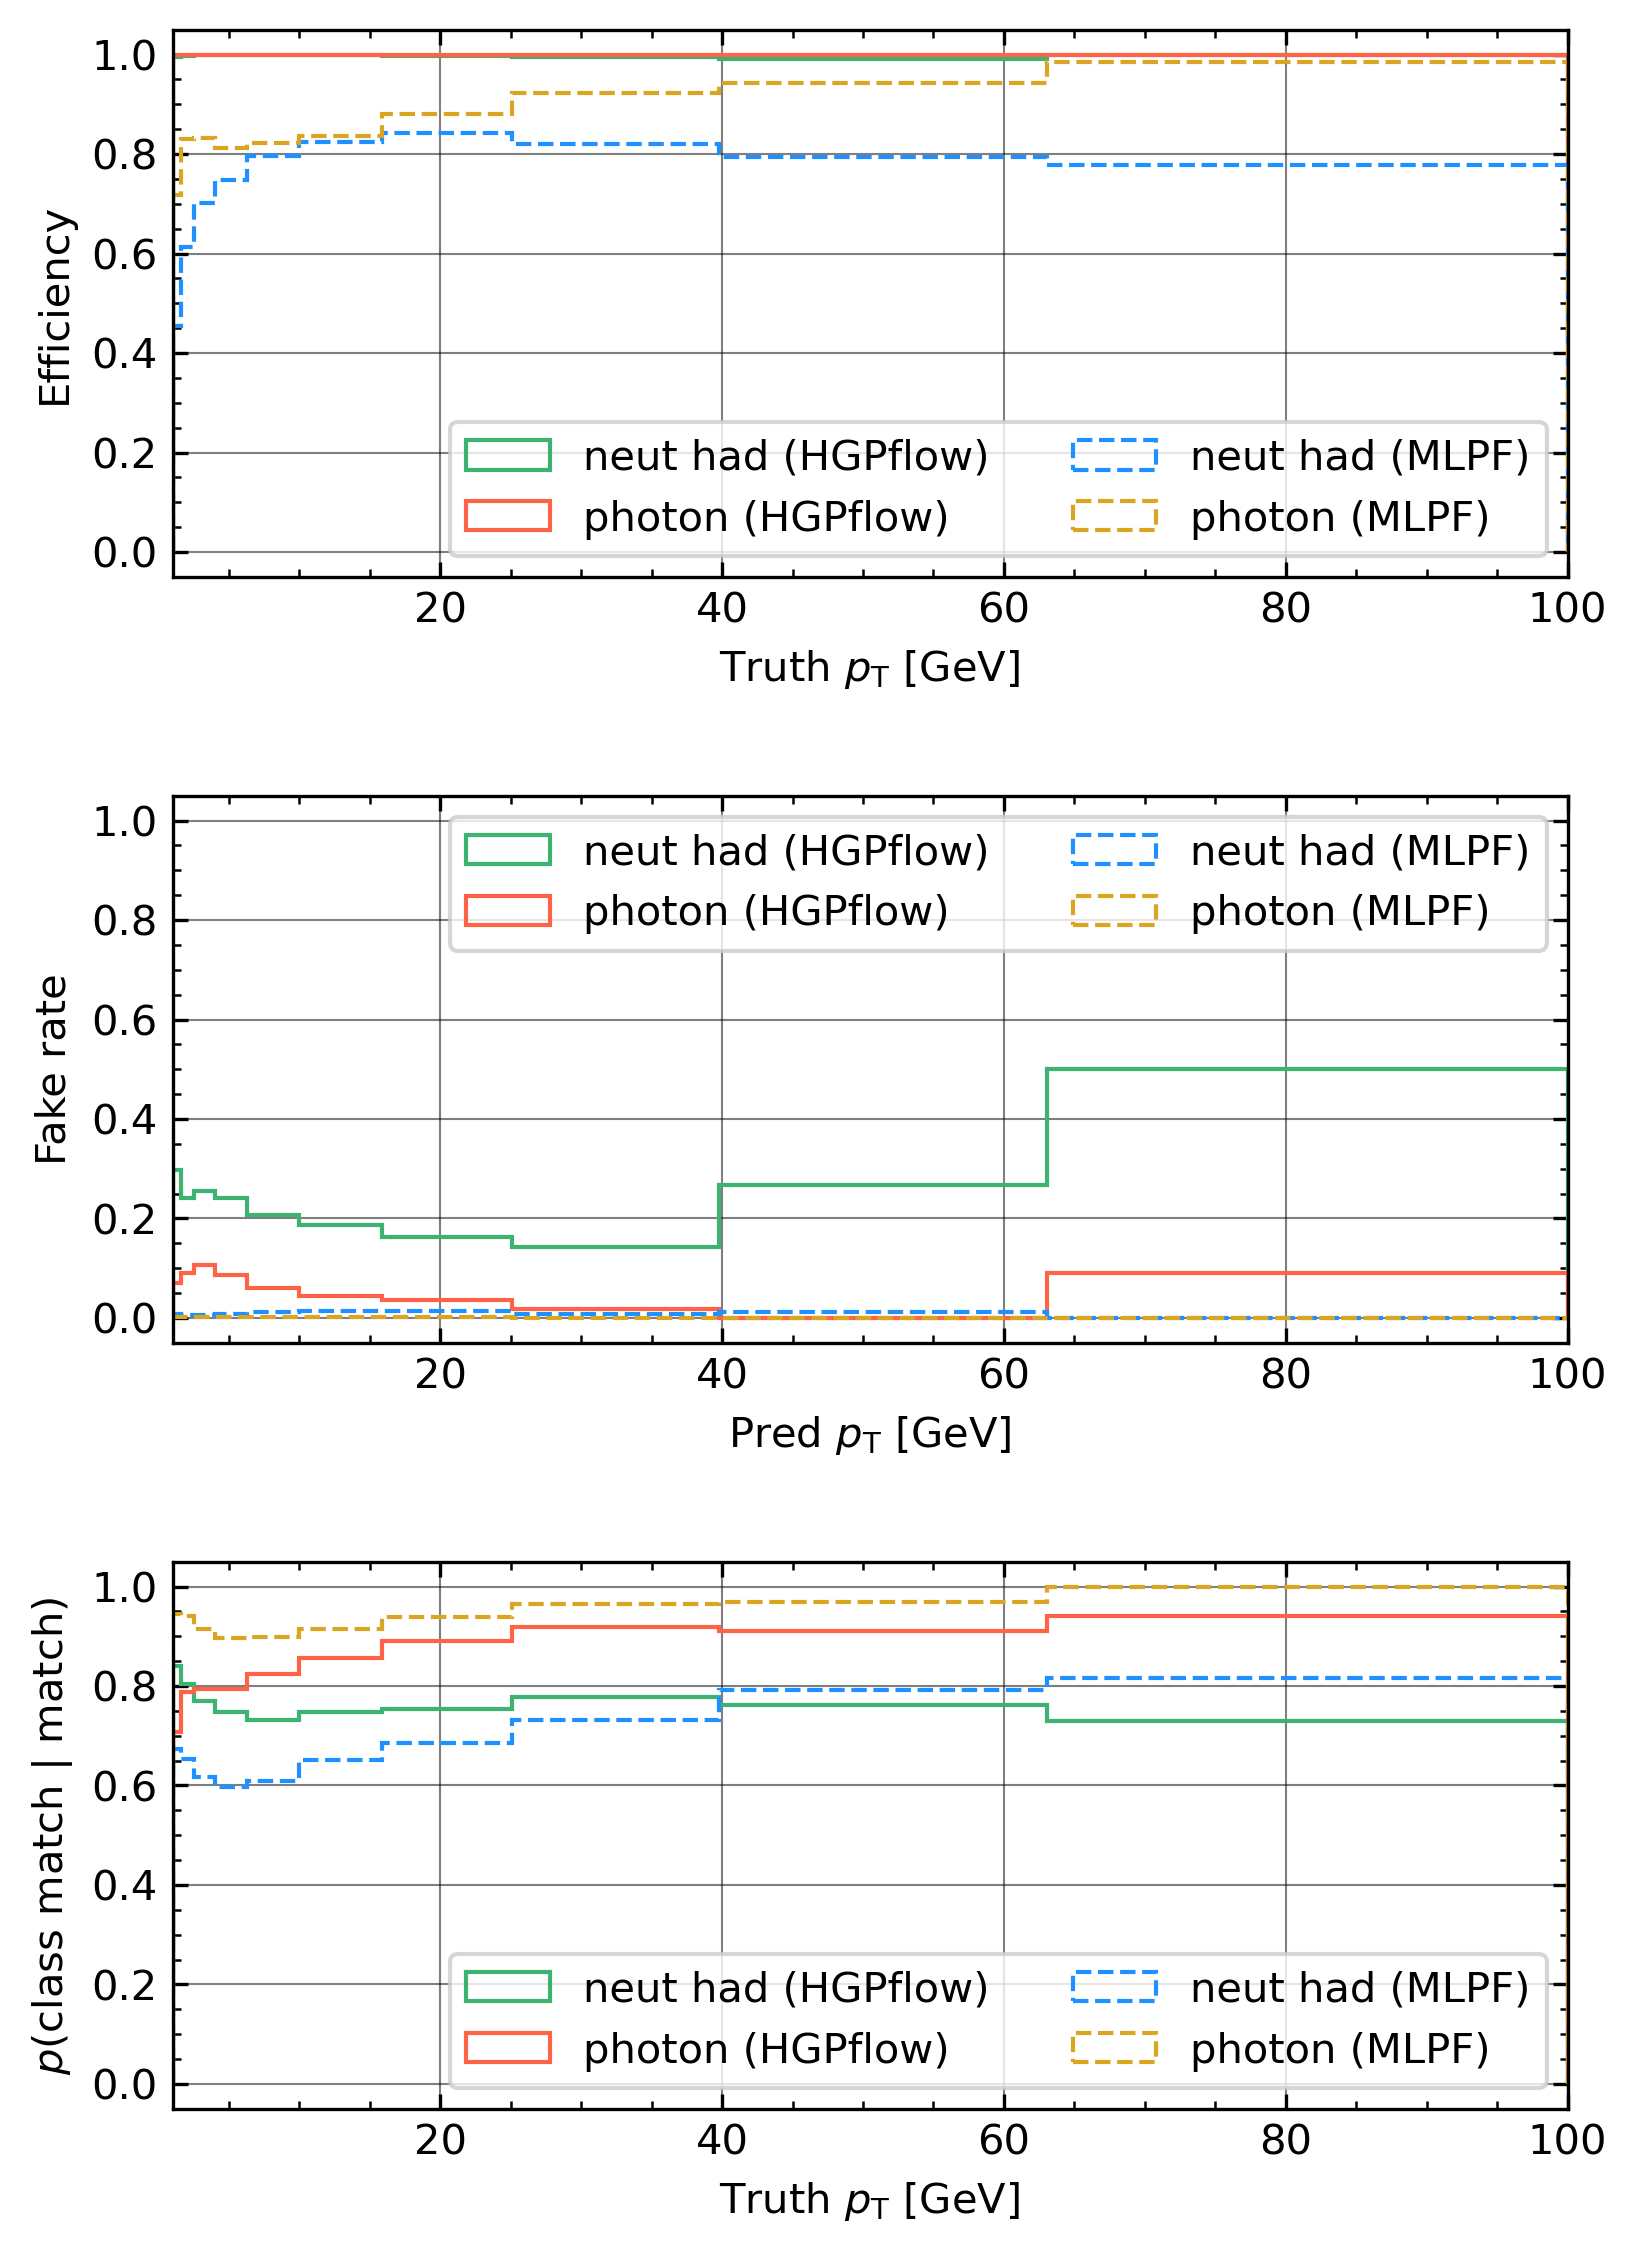

In [21]:
from hgpflow_v2.performance.plot_helper_particle import plot_eff_fr_purity

eff_fr_purity_input_dict = {
    'hgpflow': {
        'ref_matched': perf_obj_mini.hgpflow_dict['matched_hgpflow_particles'][0],
        'comp_matched': perf_obj_mini.hgpflow_dict['matched_hgpflow_particles'][1],
        'ref_unmatched': perf_obj_mini.hgpflow_dict['matched_hgpflow_particles'][2],
        'comp_unmatched': perf_obj_mini.hgpflow_dict['matched_hgpflow_particles'][3],
    },
    'mlpf': {
        'ref_matched': perf_obj_mini.mlpf_dict['matched_mlpf_particles'][0],
        'comp_matched': perf_obj_mini.mlpf_dict['matched_mlpf_particles'][1],
        'ref_unmatched': perf_obj_mini.mlpf_dict['matched_mlpf_particles'][2],
        'comp_unmatched': perf_obj_mini.mlpf_dict['matched_mlpf_particles'][3],
    }
}

fig = plot_eff_fr_purity(eff_fr_purity_input_dict, stylesheet=style_sheet_eff_fr)
if SAVE_FIG:
    fig.savefig(f'{save_dir}/dijet_eff_fr_purity.png', dpi=300, bbox_inches='tight')

#### MET and HT

(<Figure size 1200x1350 with 1 Axes>, <Figure size 1200x1350 with 1 Axes>)

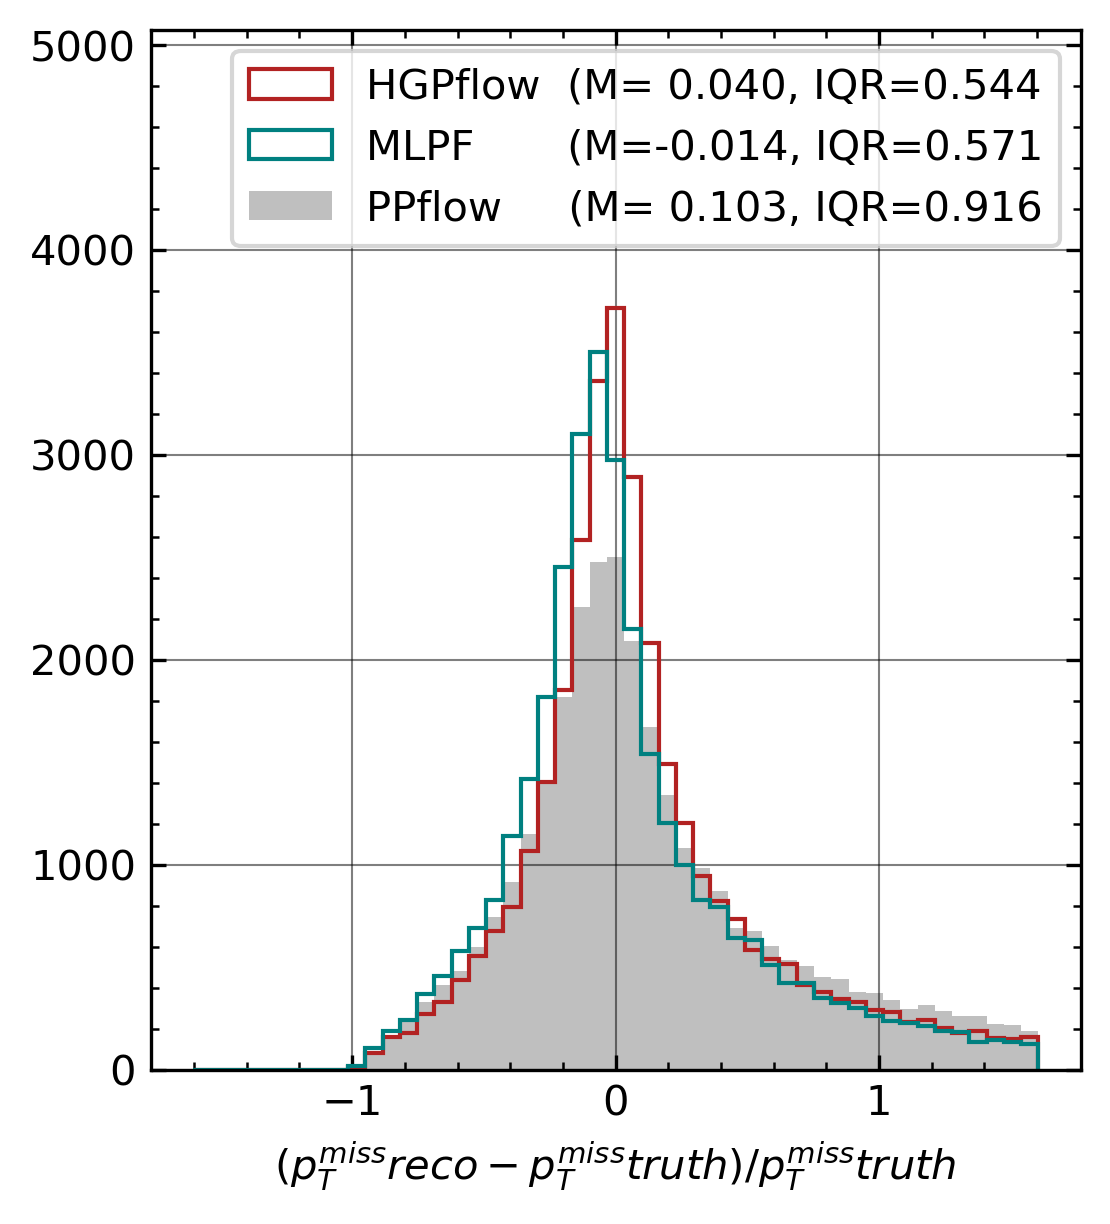

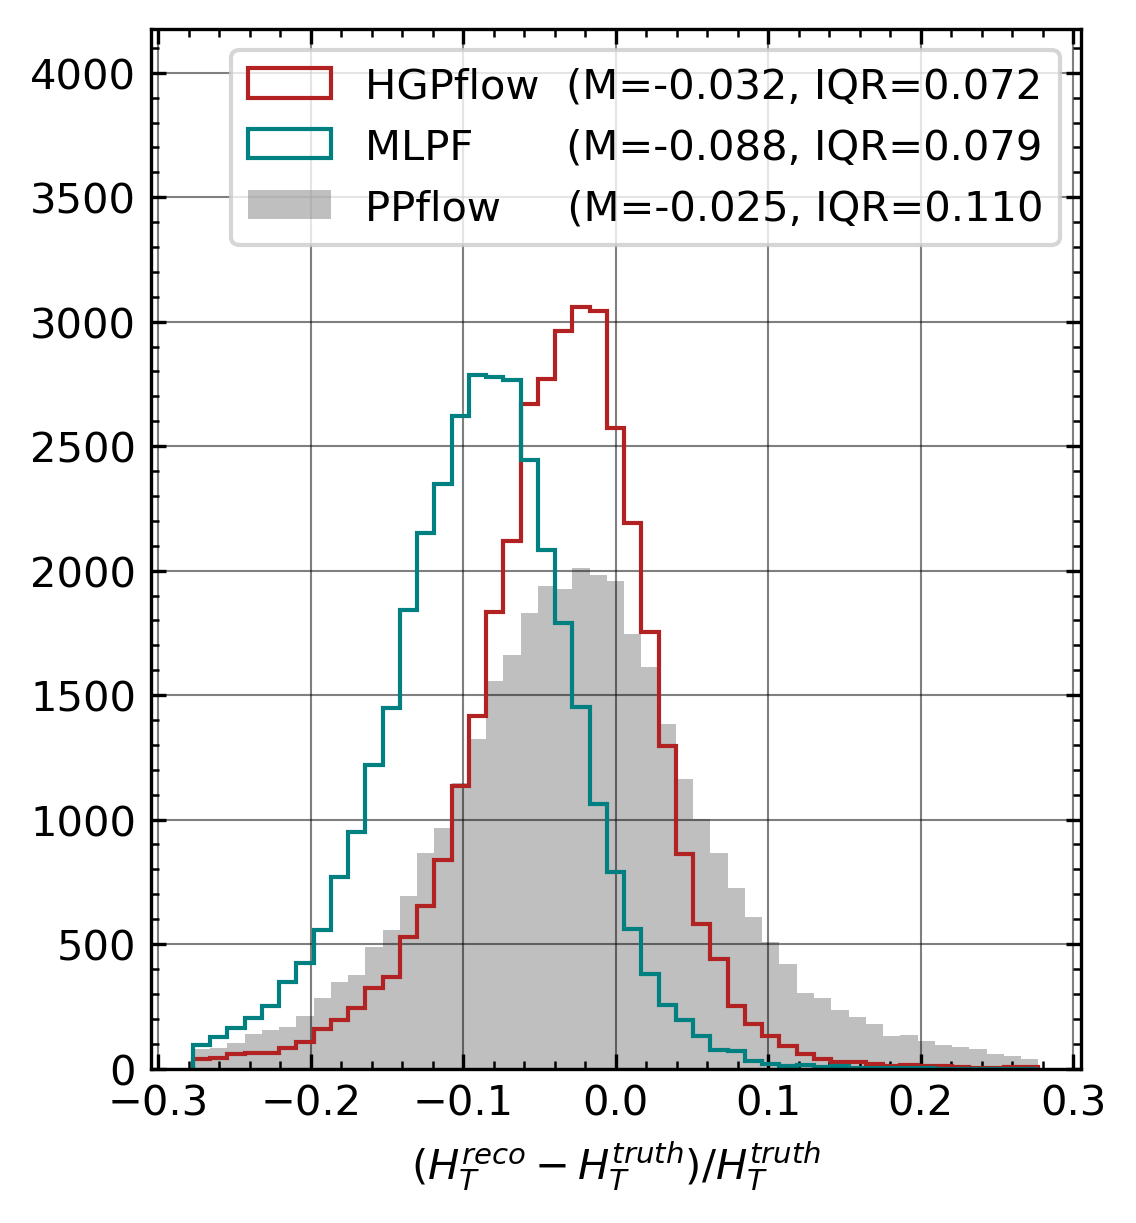

In [27]:
from hgpflow_v2.performance.plot_helper_event import plot_met_res_and_ht_res

met_res_and_ht_res_input_dict = {
    'hgpflow': [perf_obj_mini.hgpflow_dict['hgpflow_pt'], perf_obj_mini.hgpflow_dict['hgpflow_phi']],

    'mlpf': [perf_obj_mini.mlpf_dict['pred_pt'], perf_obj_mini.mlpf_dict['pred_phi']],
    'ppflow': [perf_obj_mini.truth_dict['pflow_pt'], perf_obj_mini.truth_dict['pflow_phi']],
}
plot_met_res_and_ht_res(perf_obj_mini.truth_dict['particle_pt'], perf_obj_mini.truth_dict['particle_phi'], met_res_and_ht_res_input_dict, stylesheet=style_sheet)

#### Particle residuals

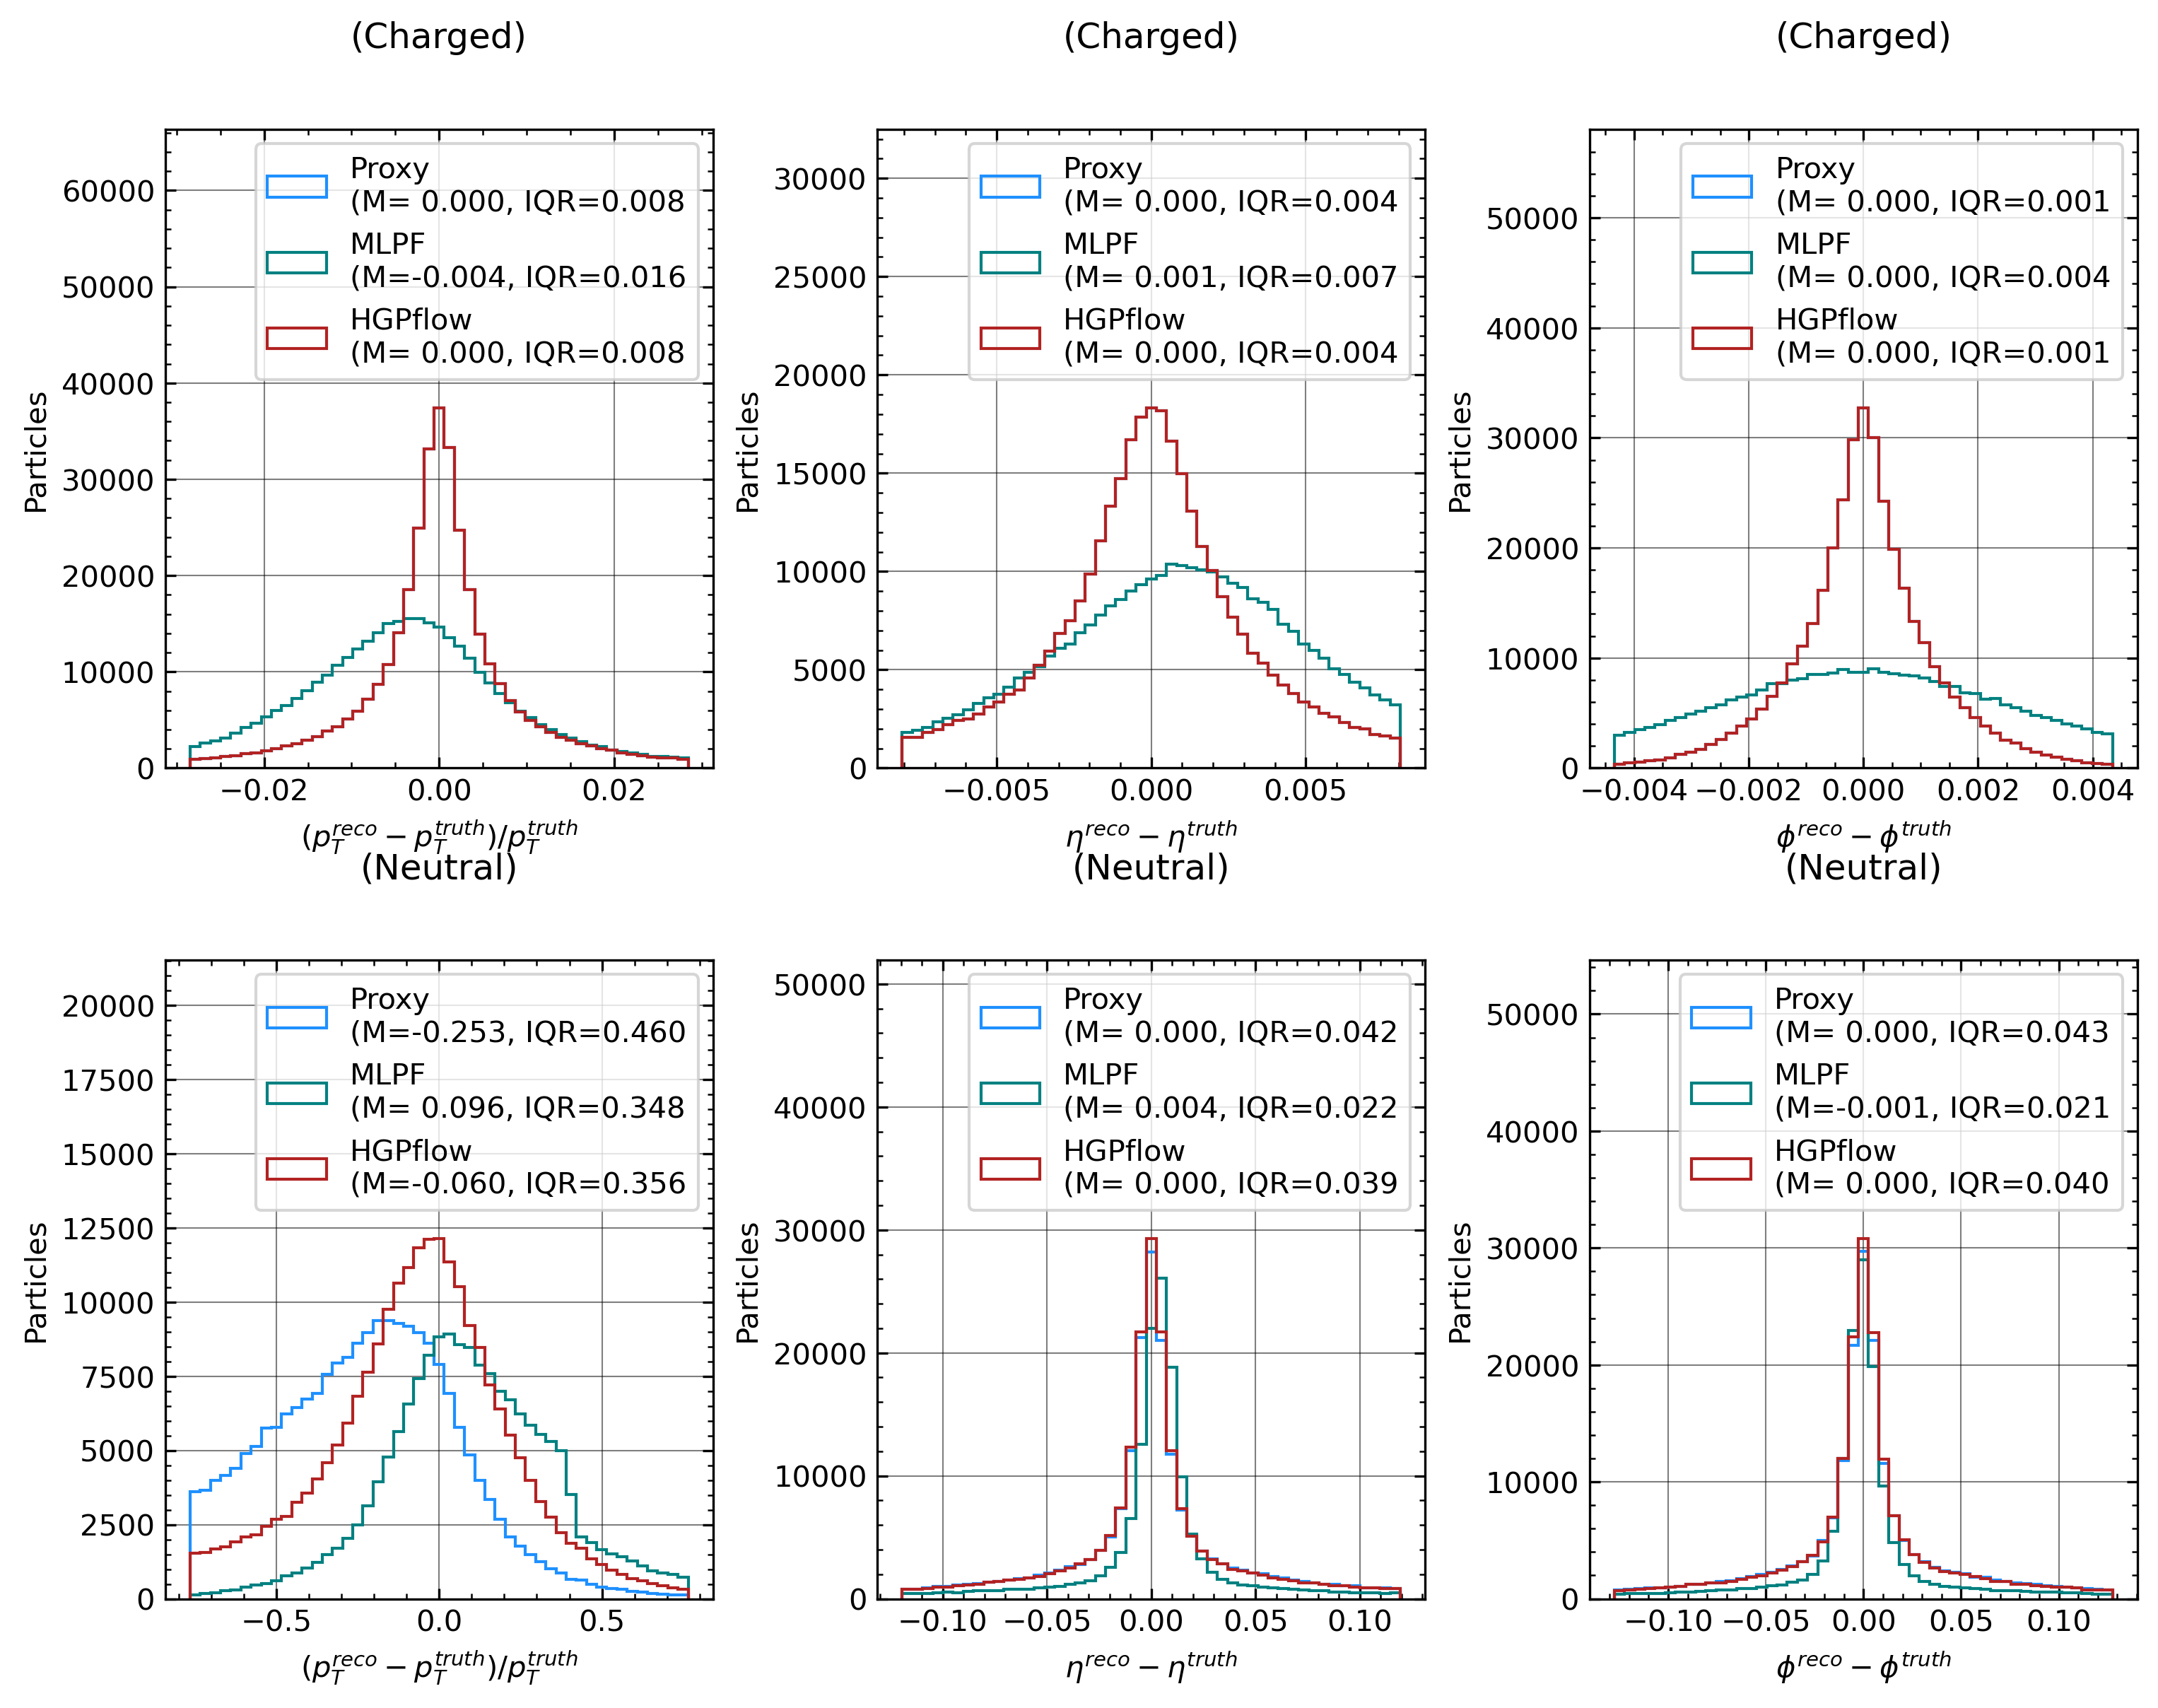

In [11]:
from hgpflow_v2.performance.plot_helper_particle import plot_residuals

style_sheet_part_res = deepcopy(style_sheet)
style_sheet_part_res['COLORS']['proxy'] = 'dodgerblue'
style_sheet_part_res['LINE_STYLES']['proxy'] = '-'

_dict = {
    'proxy': perf_obj_mini.hgpflow_dict['matched_proxy_particles'],
    'mlpf': perf_obj_mini.mlpf_dict['matched_mlpf_particles'],
    'hgpflow': perf_obj_mini.hgpflow_dict['matched_hgpflow_particles'],
}

qs = {
    'Charged': {'pt': 90, 'eta': 80, 'phi': 80}, 
    'Neutral': {'pt': 90, 'eta': 80, 'phi': 80}
}
fig = plot_residuals(_dict, pt_relative=True, log_y=False, qs=qs, stylesheet=style_sheet_part_res)
if SAVE_FIG:
    fig.savefig(f'{save_dir}/dijet_particle_residuals.png', dpi=300, bbox_inches='tight')

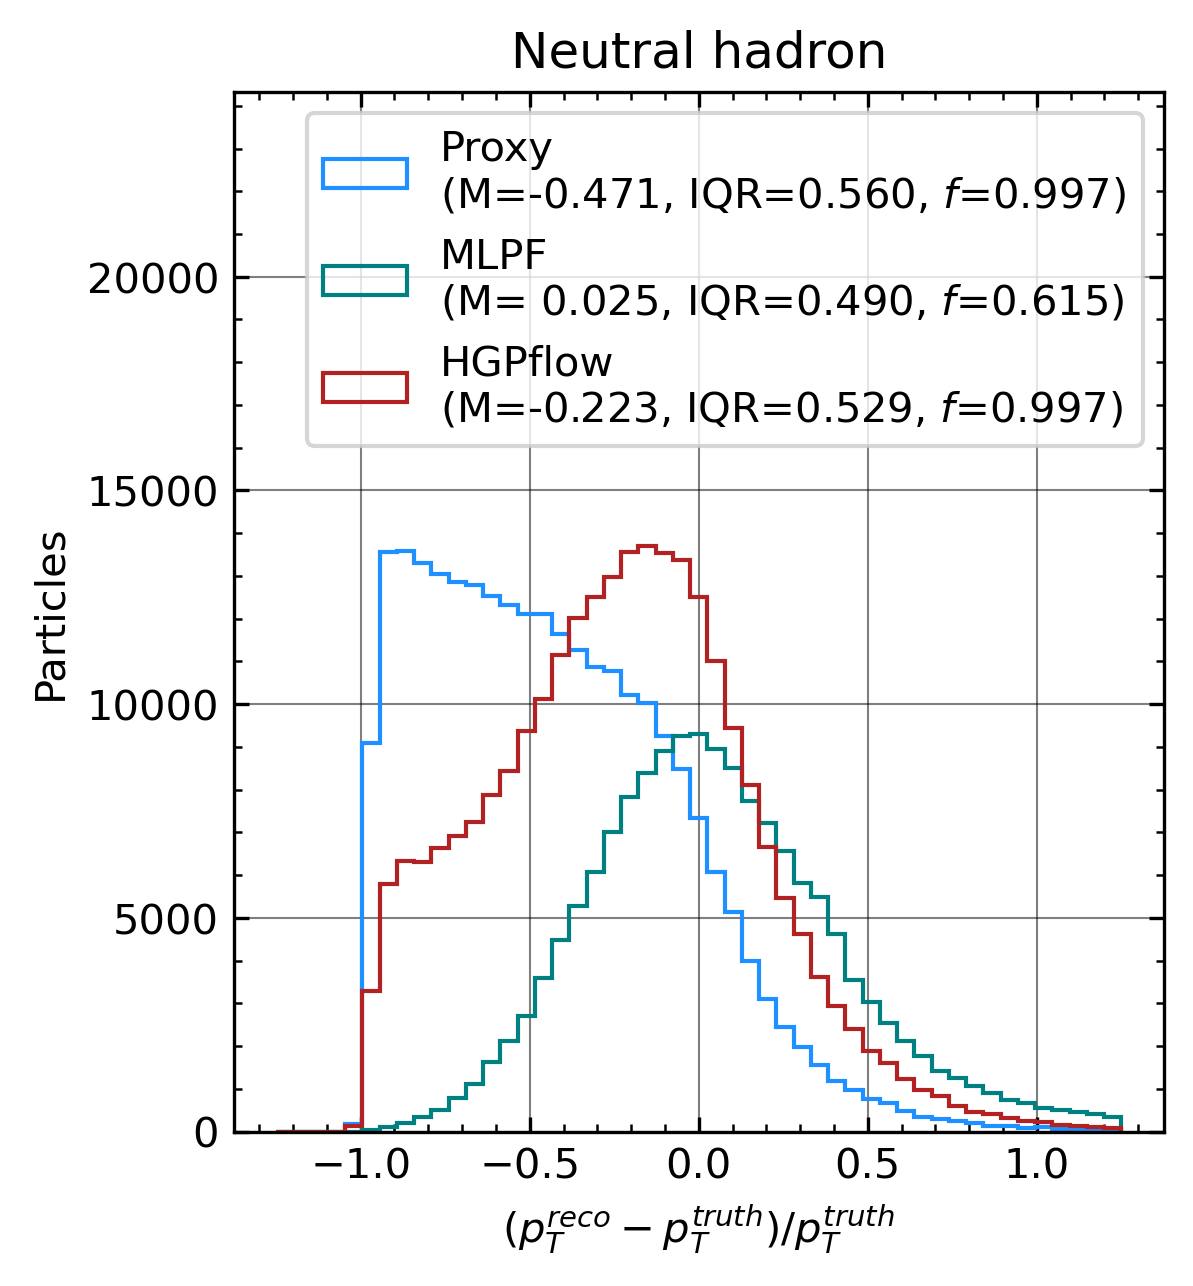

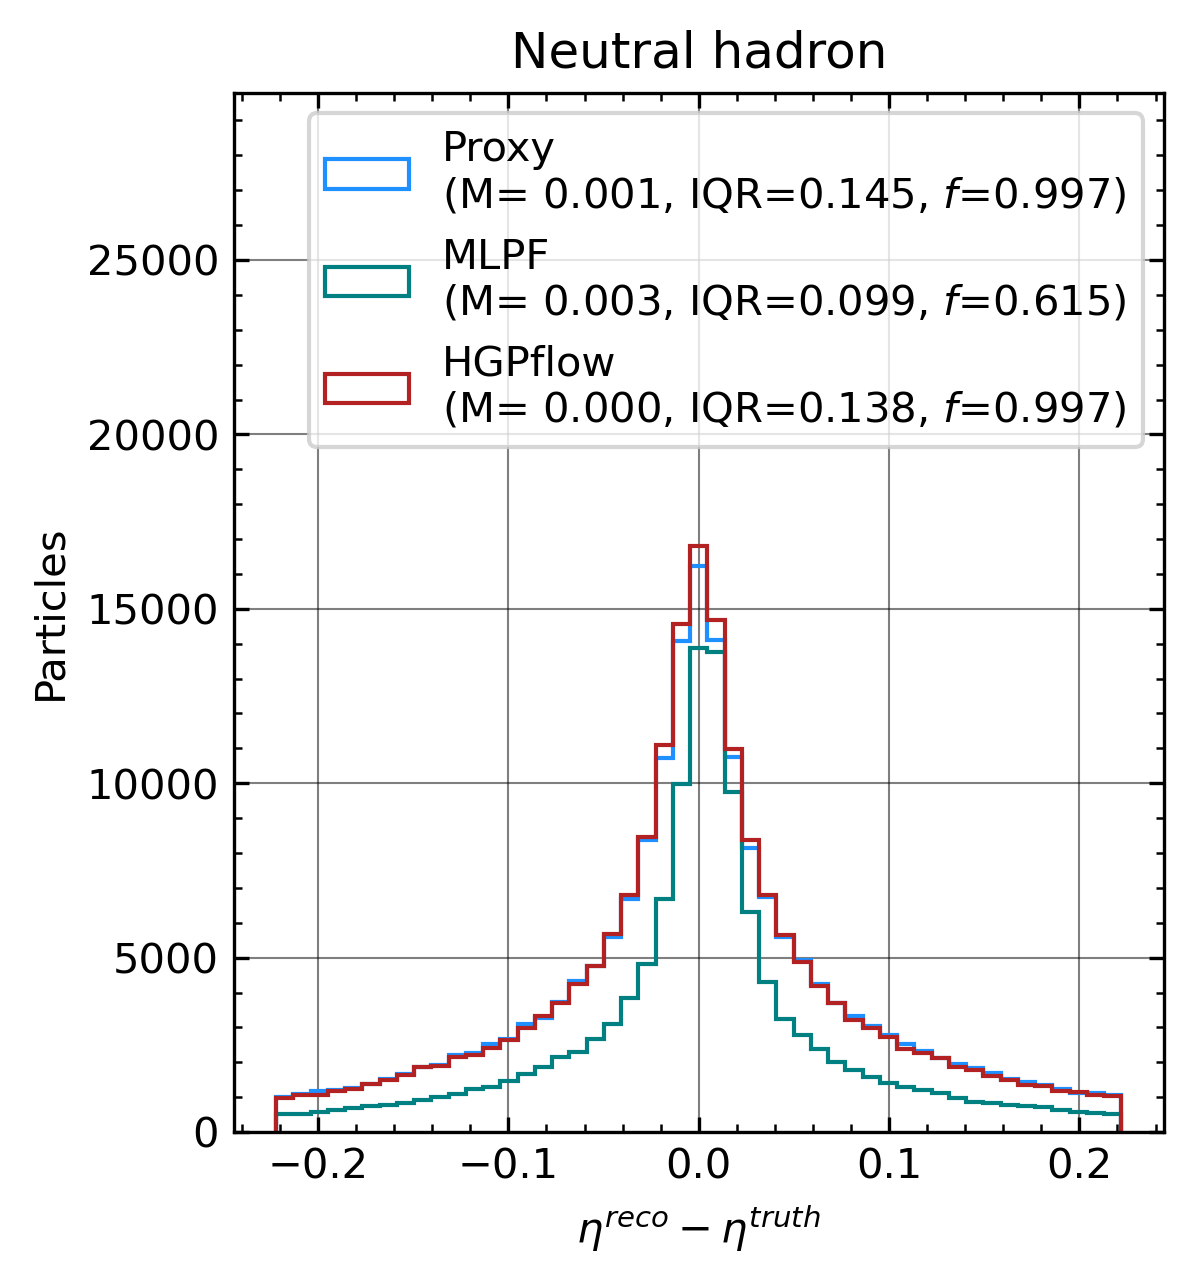

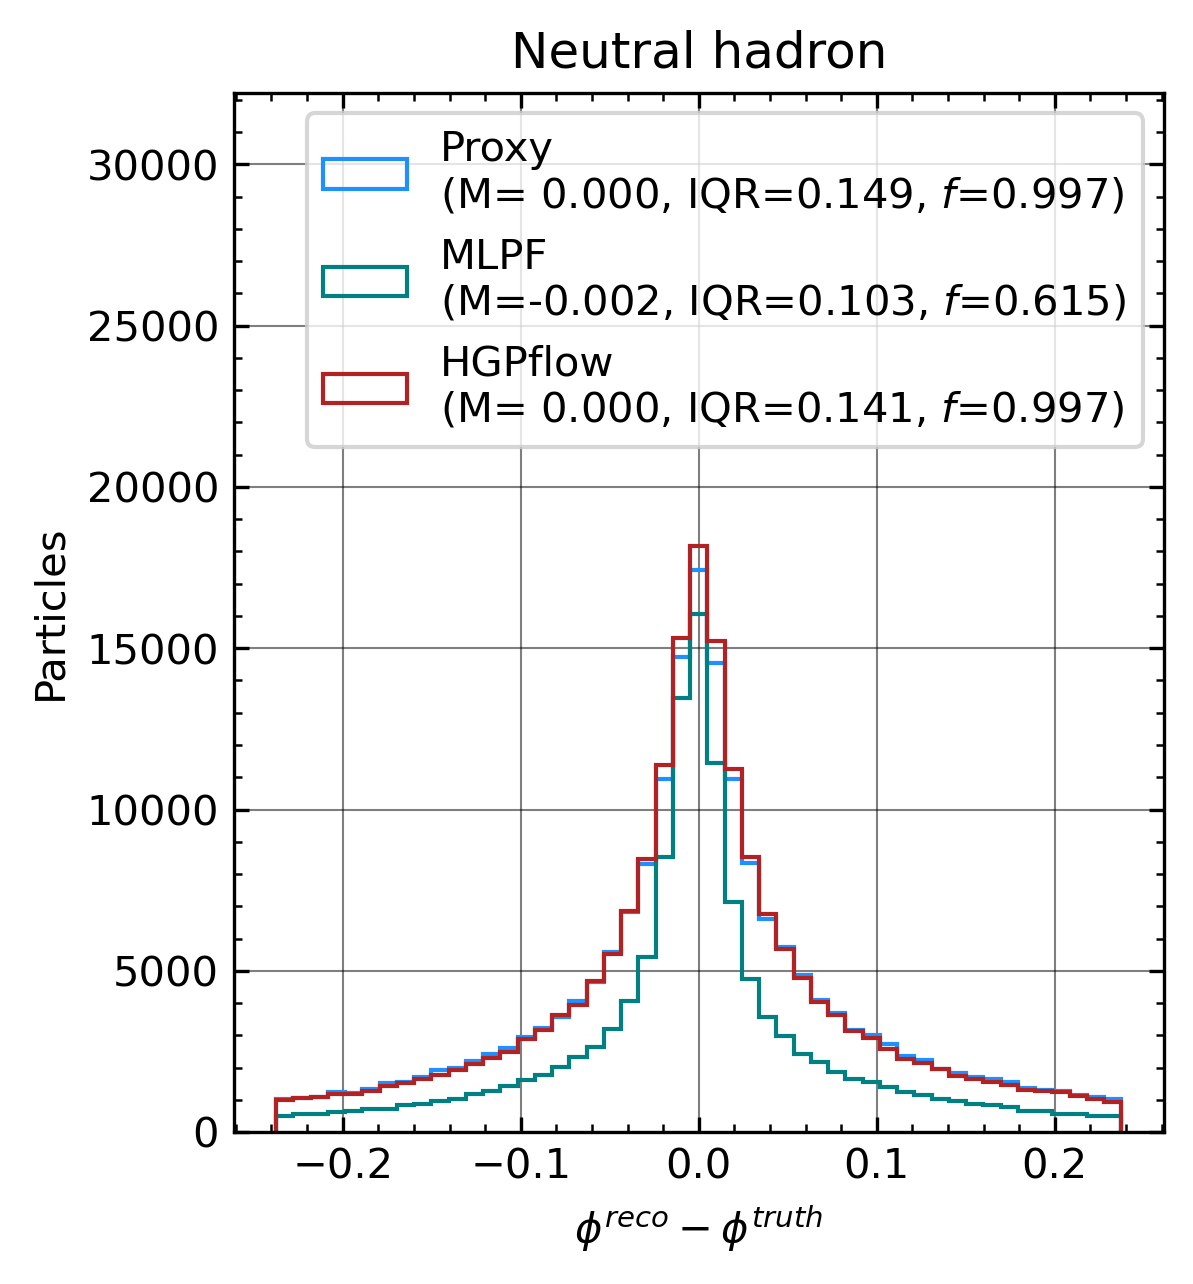

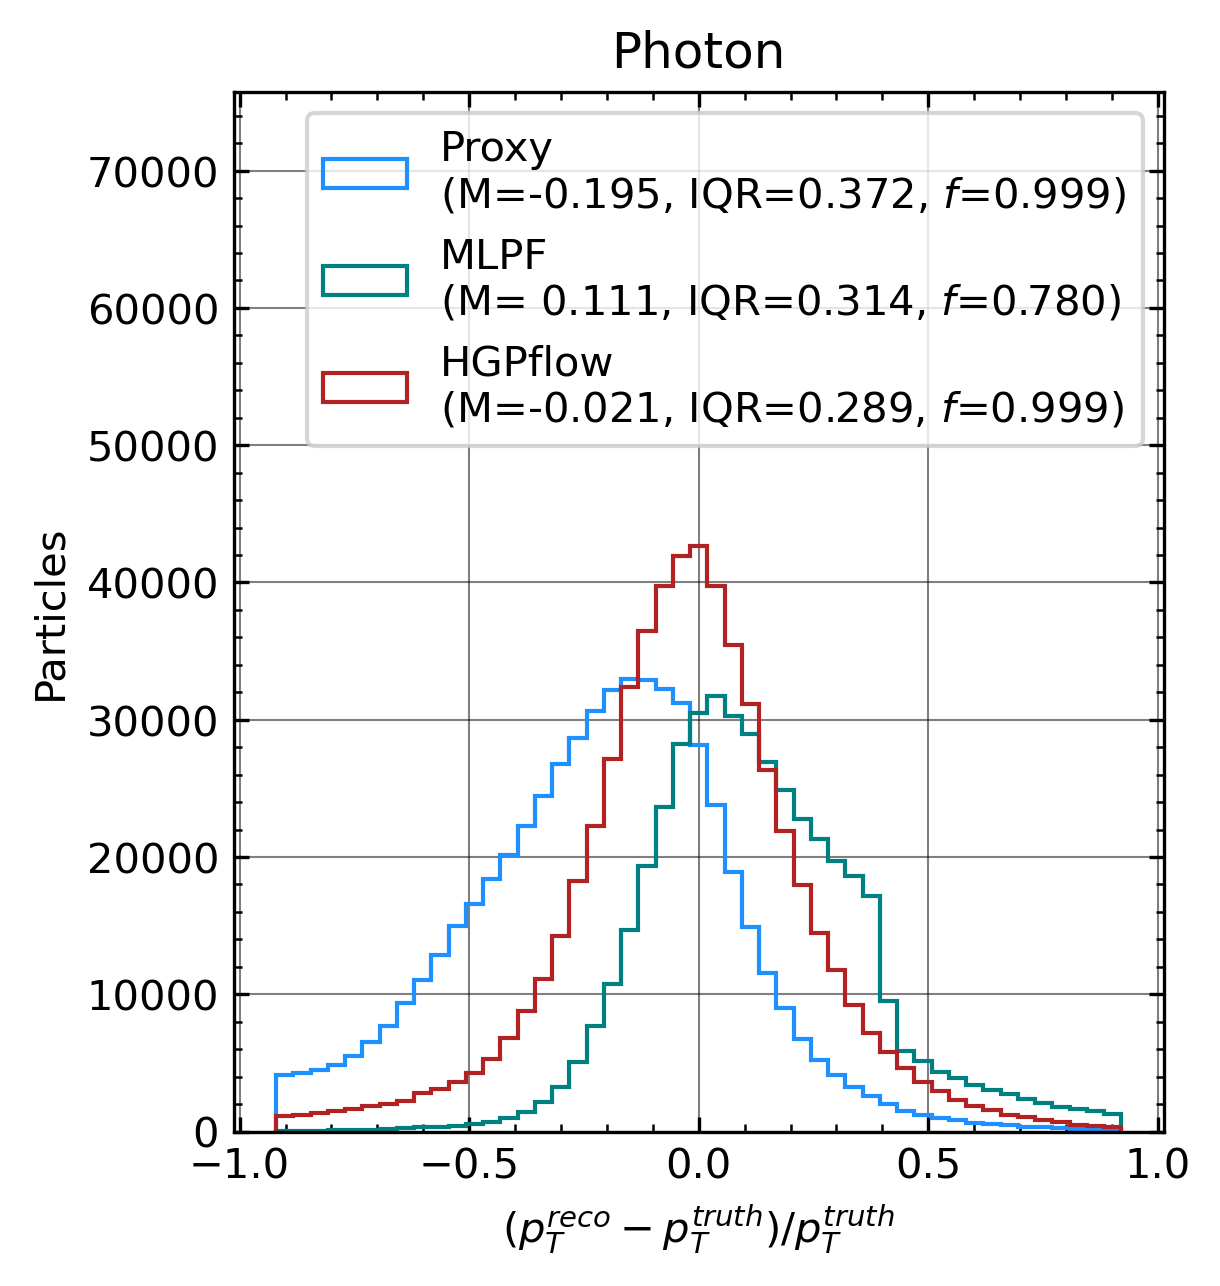

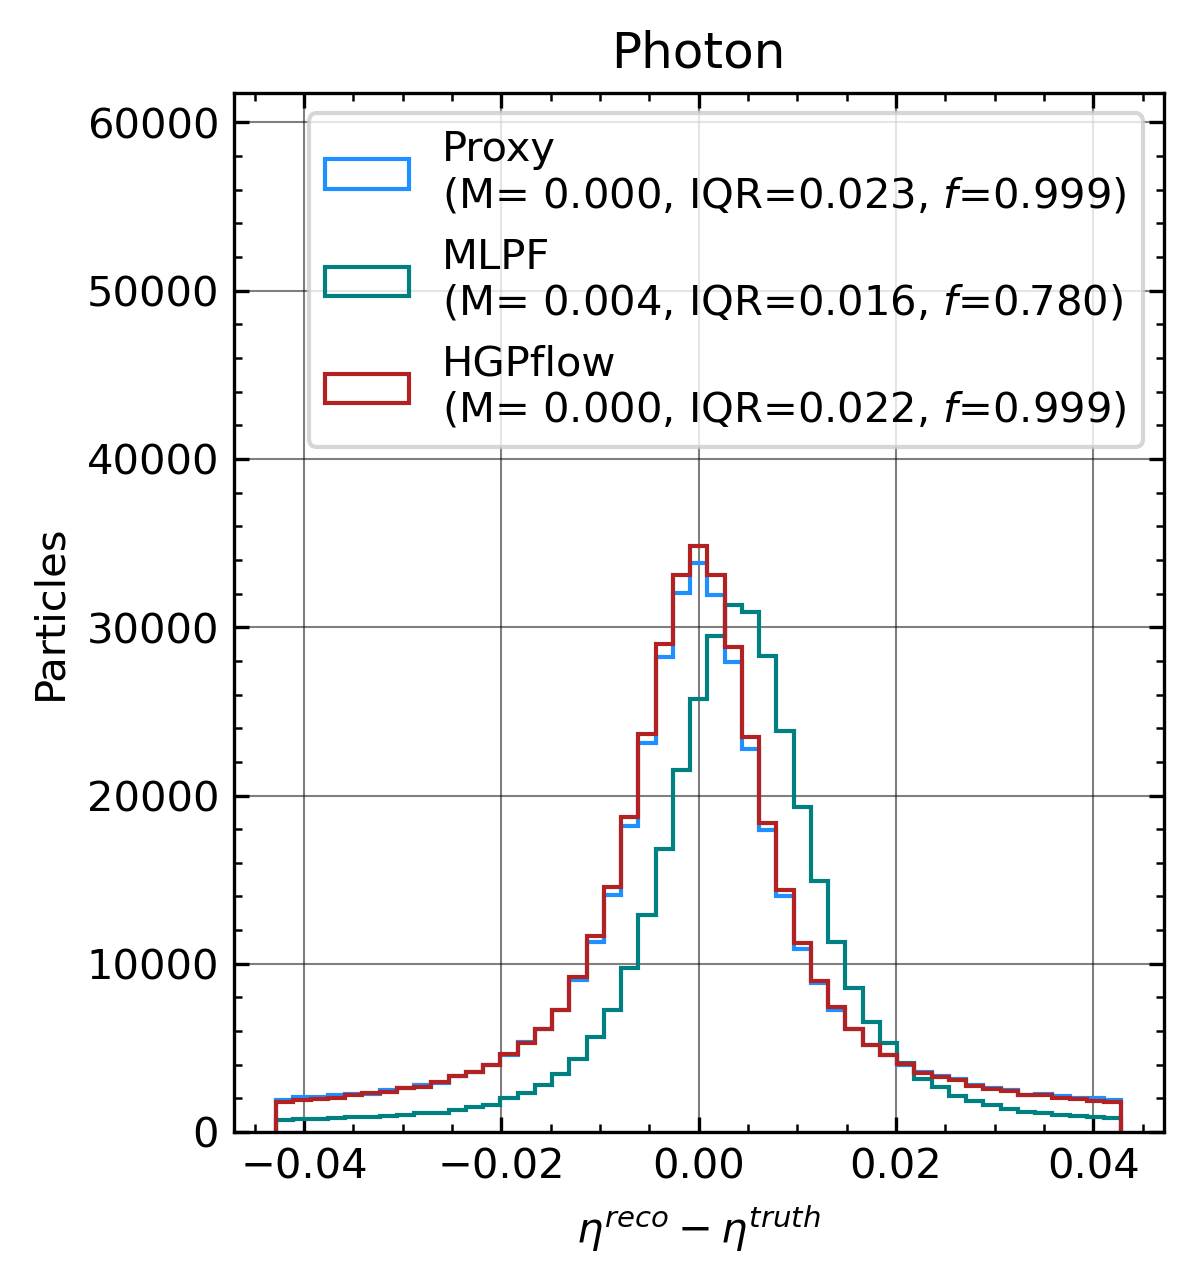

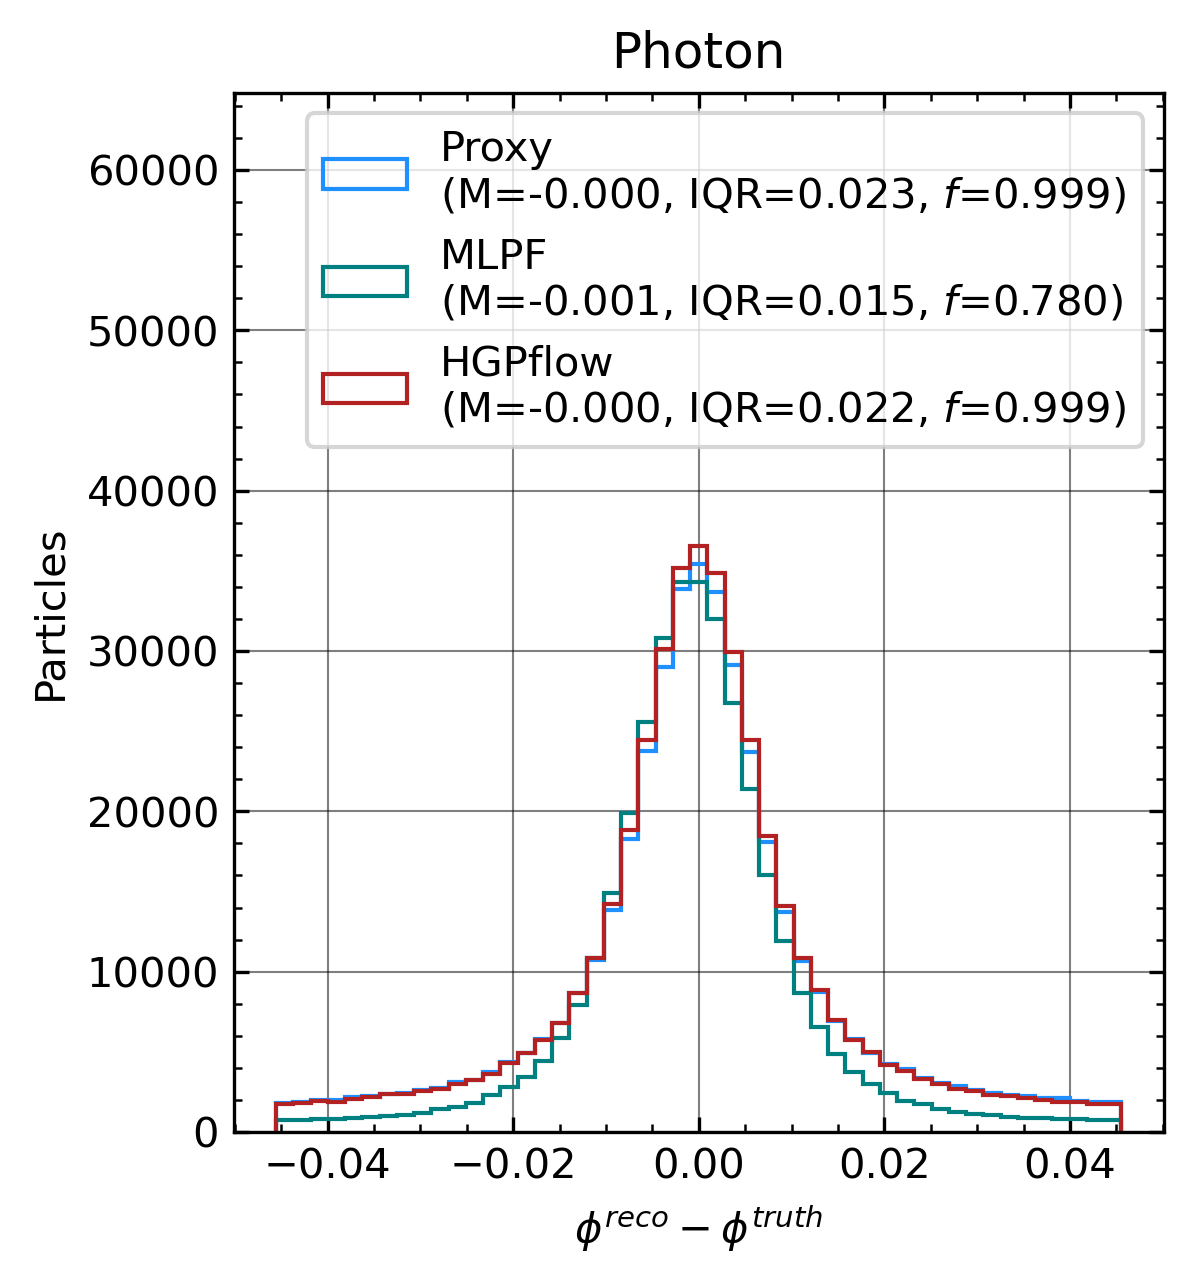

In [14]:
from hgpflow_v2.performance.plot_helper_particle import plot_residuals_neutrals

_dict = {
    'proxy': perf_obj_mini.hgpflow_dict['matched_proxy_particles'],
    'mlpf': perf_obj_mini.mlpf_dict['matched_mlpf_particles'],
    'hgpflow': perf_obj_mini.hgpflow_dict['matched_hgpflow_particles'],
}

qs = {
    'Neutral hadron': {'pt': 98, 'eta': 75, 'phi': 75}, 
    'Photon': {'pt': 99, 'eta': 90, 'phi': 90}
}
figs = plot_residuals_neutrals(_dict, pt_relative=True, log_y=False, qs=qs, stylesheet=style_sheet_part_res, separate_figures=True)
if SAVE_FIG:
    figs[0].savefig(f'{save_dir}/dijet_particle_residuals_neutralhad_pt.png', dpi=300, bbox_inches='tight')
    figs[1].savefig(f'{save_dir}/dijet_particle_residuals_neutralhad_eta.png', dpi=300, bbox_inches='tight')
    figs[2].savefig(f'{save_dir}/dijet_particle_residuals_neutralhad_phi.png', dpi=300, bbox_inches='tight')
    figs[3].savefig(f'{save_dir}/dijet_particle_residuals_photon_pt.png', dpi=300, bbox_inches='tight')
    figs[4].savefig(f'{save_dir}/dijet_particle_residuals_photon_eta.png', dpi=300, bbox_inches='tight')
    figs[5].savefig(f'{save_dir}/dijet_particle_residuals_photon_phi.png', dpi=300, bbox_inches='tight')

# Single pion

In [ ]:
single_pion_paths = {
    '2': {
        'truth': 'path to pion bin0.root',
        'pred': 'path to HGPflow prediction pion bin0.root',
        'mlpf': 'path to MLPF prediction pion bin0.root'
    },
    '5': {
        'truth': 'path to pion bin1.root',
        'pred': 'path to HGPflow prediction pion bin1.root',
        'mlpf': 'path to MLPF prediction pion bin1.root'
    },
    '10': {
        'truth': 'path to pion bin2.root',
        'pred': 'path to HGPflow prediction pion bin2.root',
        'mlpf': 'path to MLPF prediction pion bi20.root'
    },
    '20': {
        'truth': 'path to pion bin3.root',
        'pred': 'path to HGPflow prediction pion bin3.root',
        'mlpf': 'path to MLPF prediction pion bin3.root'
    },
    '40': {
        'truth': 'path to pion bin4.root',
        'pred': 'path to HGPflow prediction pion bin4.root',
        'mlpf': 'path to MLPF prediction pion bin4.root'
    },
    '80': {
        'truth': 'path to pion bin5.root',
        'pred': 'path to HGPflow prediction pion bin5.root',
        'mlpf': 'path to MLPF prediction pion bin5.root'
    }
}

pion_perf_objs = {}
for k, v in single_pion_paths.items():
    pion_perf_objs[k] = PerformanceCOCOA(v['truth'], v['pred'], ind_threshold=IND_THRESHOLD, topo=False, pred_path_mlpf=v['mlpf'])

In [24]:
from hgpflow_v2.performance.plot_helper_event import compute_event_energy_residuals

neut_energy_res_dict = {}
for k, p_obj in pion_perf_objs.items():
    neut_energy_res_dict[k] = compute_event_energy_residuals(
        ref = {'e': p_obj.truth_dict['particle_e'], 'charge': p_obj.truth_dict['particle_charge']},
        comp_dict = {
            'truth': {'e': p_obj.truth_dict['particle_e'], 'charge': p_obj.truth_dict['particle_charge']},
            'ppflow': {'e': p_obj.truth_dict['pflow_e'], 'charge': p_obj.truth_dict['pflow_charge']},
            'hgpflow': {'e': p_obj.hgpflow_dict['hgpflow_e'], 'charge': p_obj.hgpflow_dict['hgpflow_charge']},
            'mlpf': {'e': p_obj.mlpf_dict['pred_e'], 'charge': p_obj.mlpf_dict['pred_charge']},
        }
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 28948/28948 [00:00<00:00, 41080.45it/s]


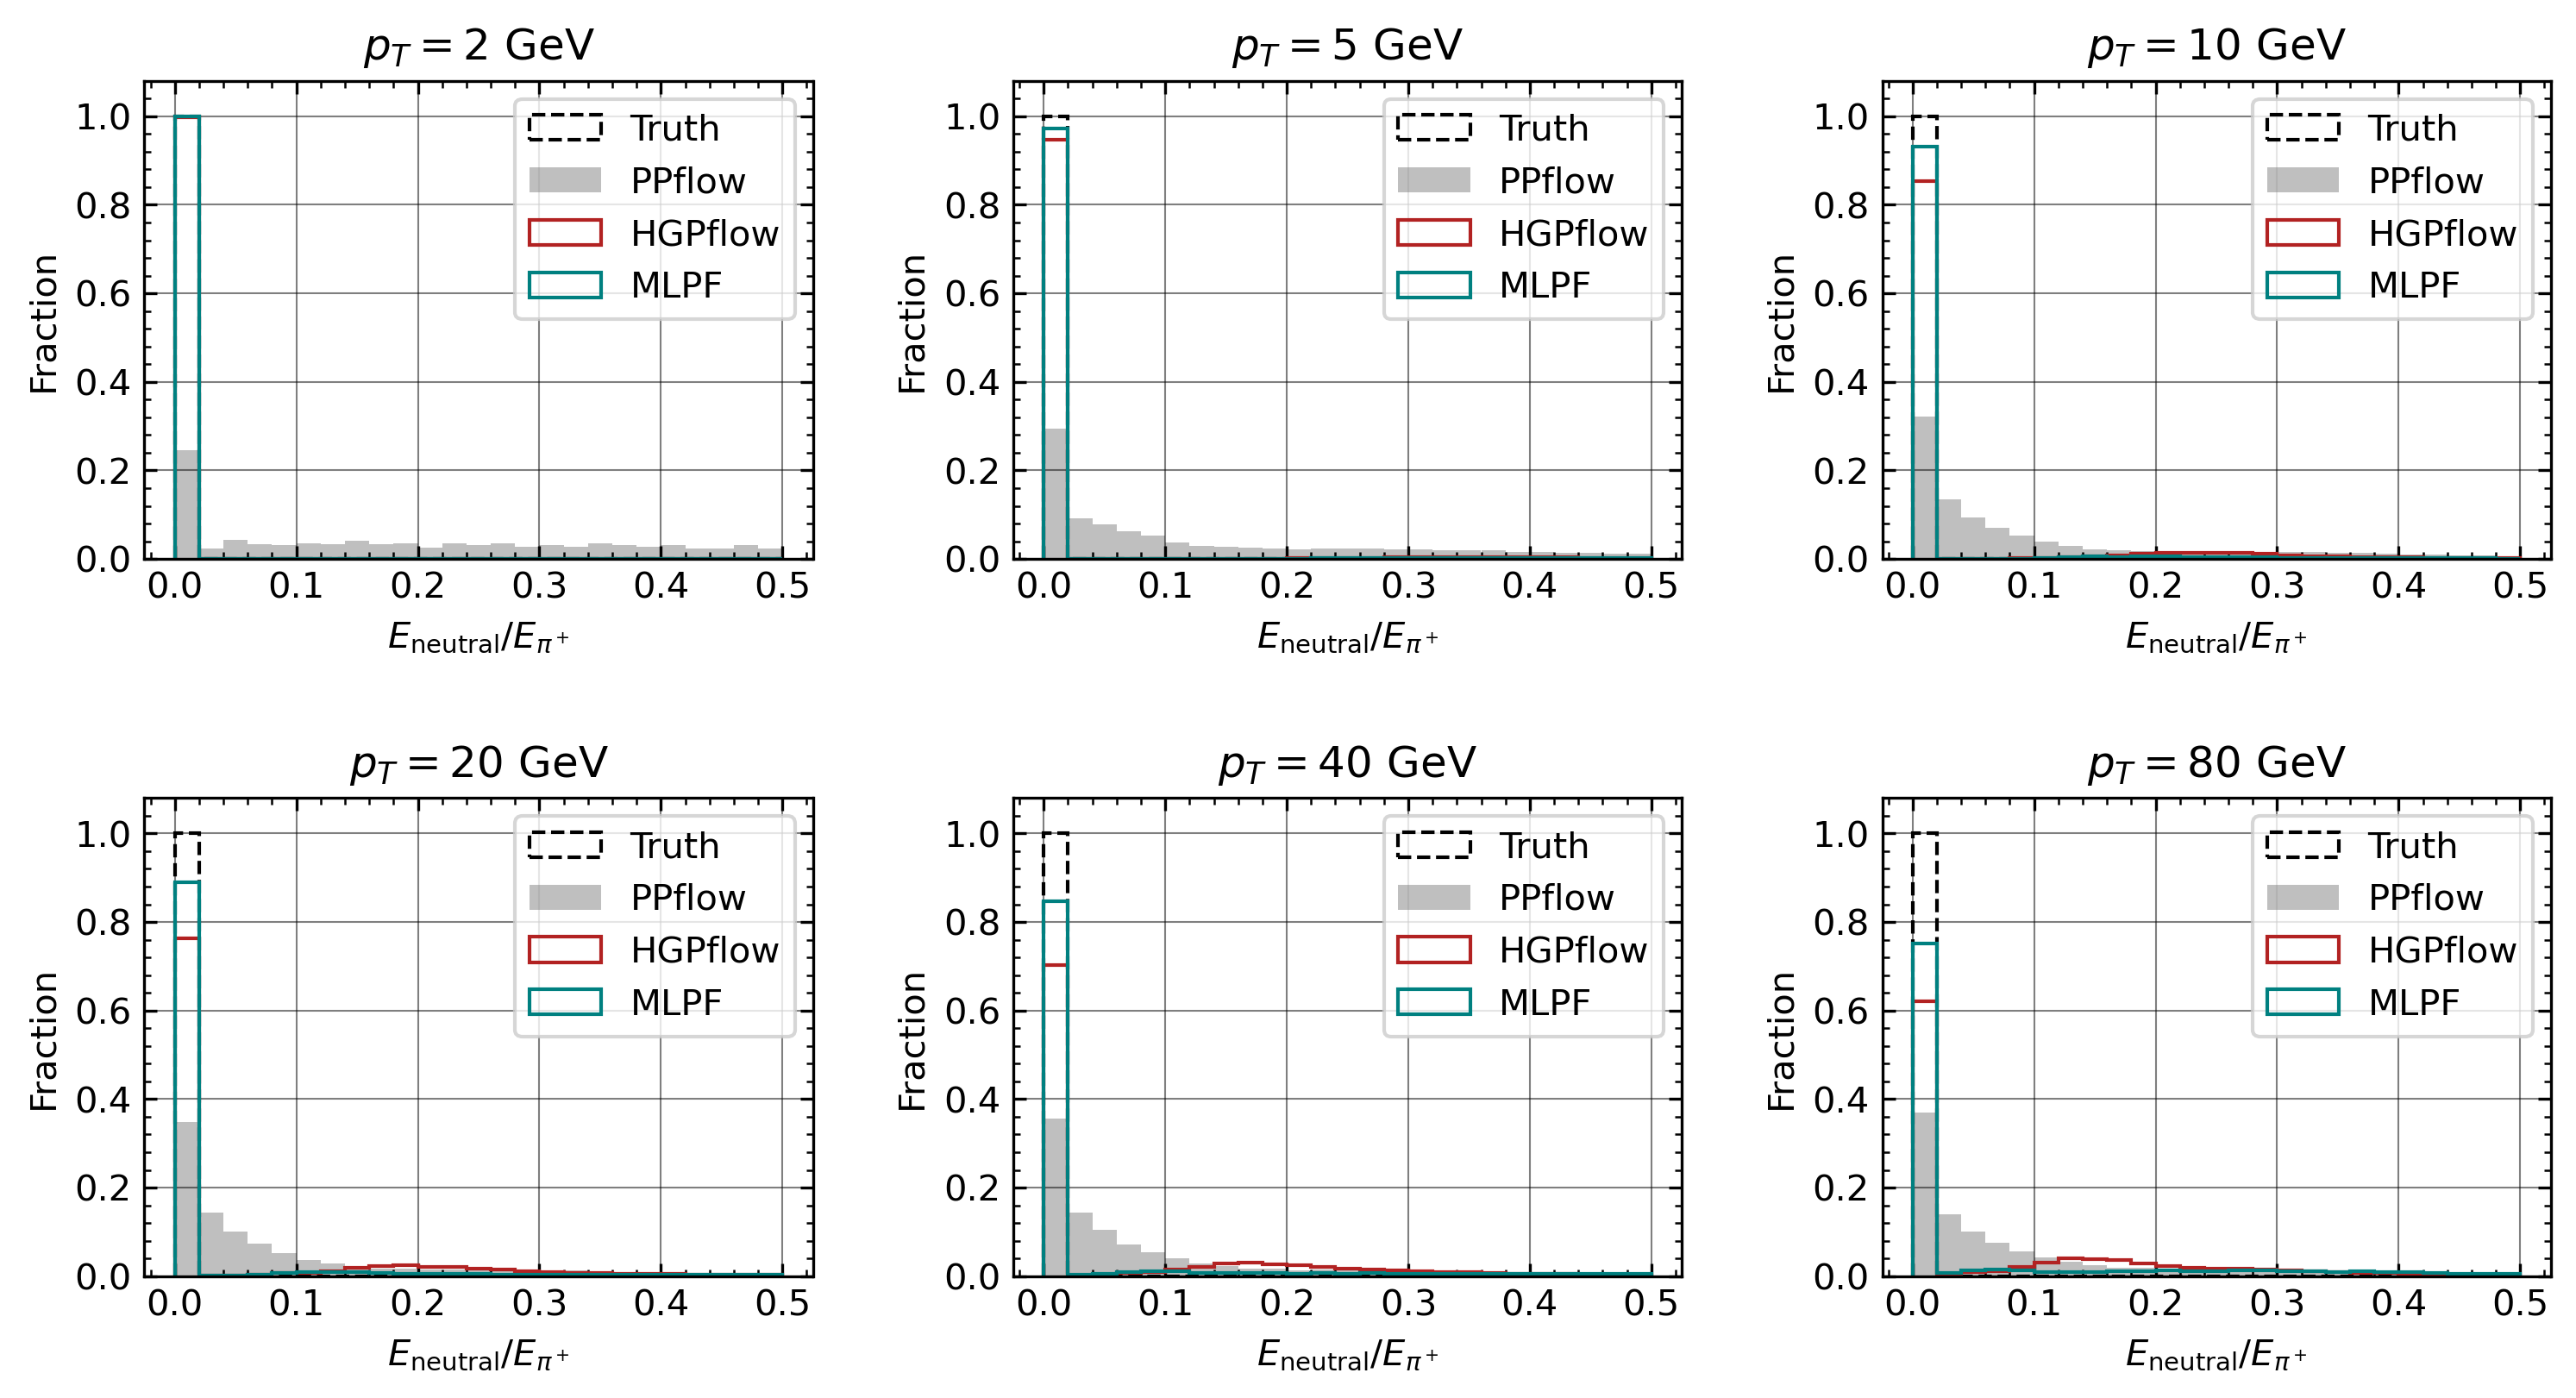

In [25]:
from hgpflow_v2.performance.plot_helper_event import plot_event_neut_energy_res

e_bins = np.array([0, 5, 10, 20, 40, 60, 80]) #, 100, 120, 140, 160, 180, 200, 250, 300, 400, 500, 1000])
fig = plot_event_neut_energy_res(ev_eres_dict=neut_energy_res_dict, stylesheet=style_sheet)
if SAVE_FIG:
    fig.savefig(f'{save_dir}/single_pion_event_energy_res.png', dpi=300)

# $t\bar{t}$

In [ ]:
truth_path = 'path to ttbar.root'
pred_path = 'path to HGPflow prediction ttbar.root'
mlpf_path = 'path to MLPF prediction ttbar.root'
perf_obj_ttbar = PerformanceCOCOA(truth_path, pred_path, ind_threshold=IND_THRESHOLD, topo=False, pred_path_mlpf=mlpf_path)

#### MET and HT

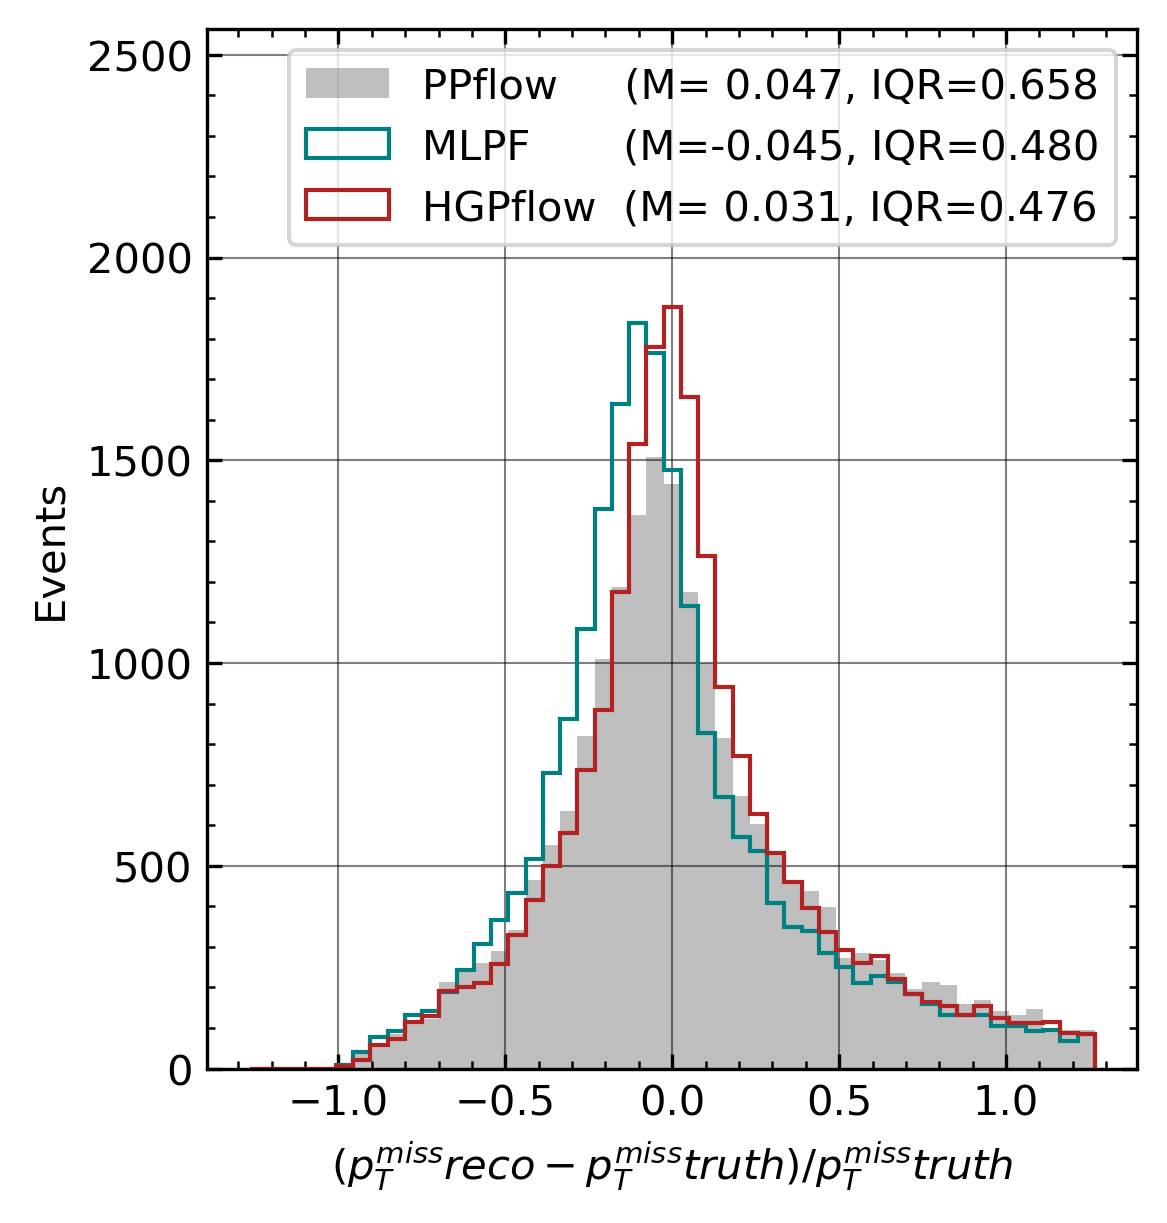

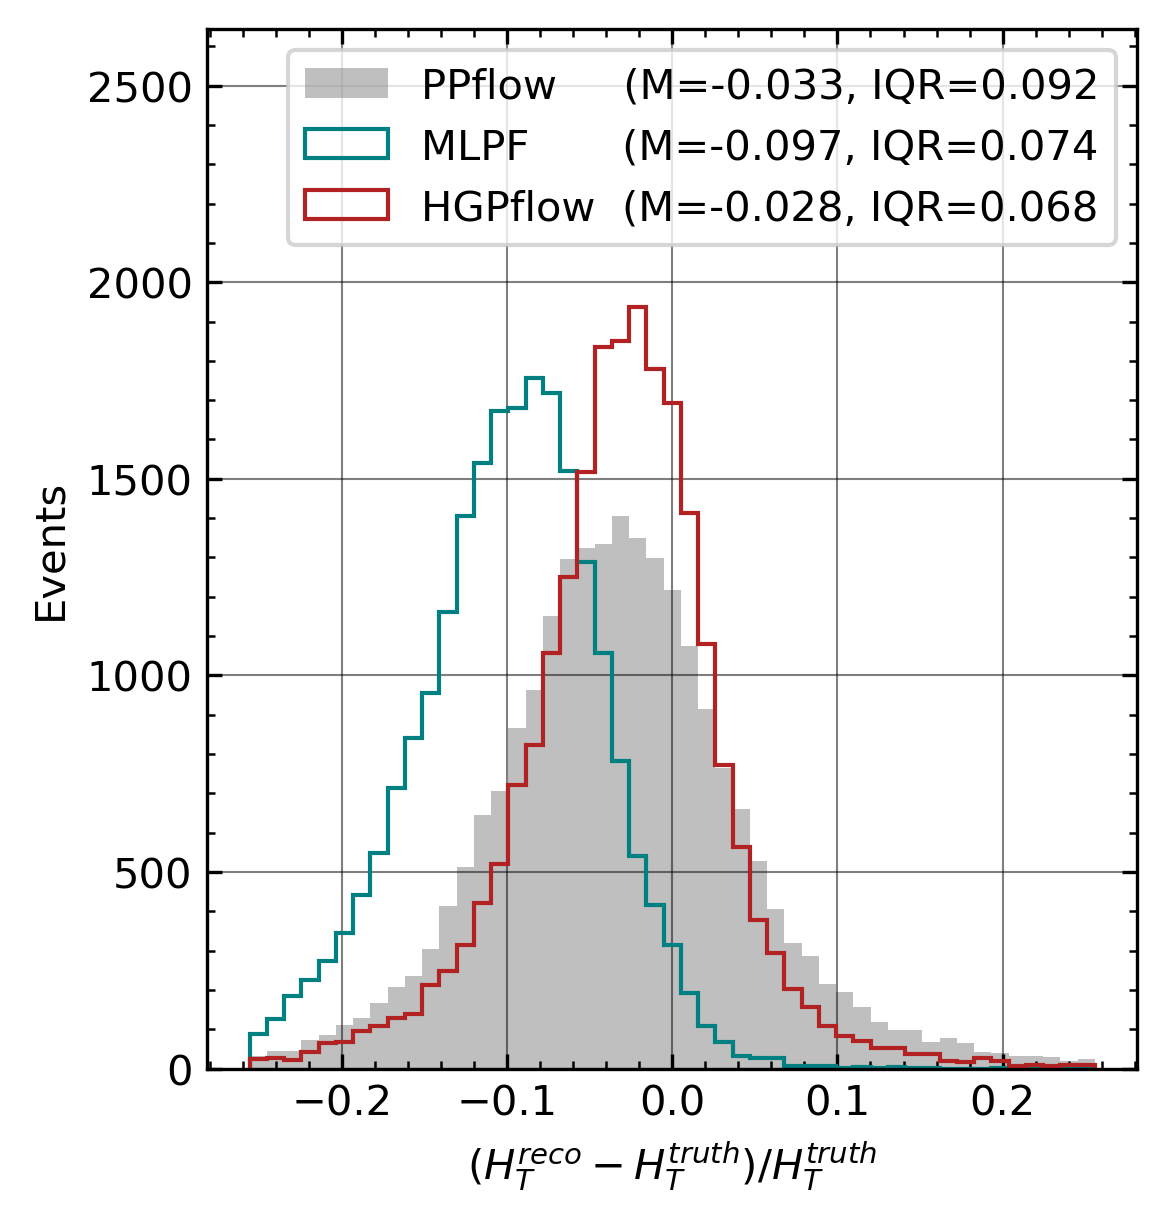

In [13]:
from hgpflow_v2.performance.plot_helper_event import plot_met_res_and_ht_res

met_res_and_ht_res_input_dict_ttbar = {
    'ppflow': [perf_obj_ttbar.truth_dict['pflow_pt'], perf_obj_ttbar.truth_dict['pflow_phi']],
    'mlpf': [perf_obj_ttbar.mlpf_dict['pred_pt'], perf_obj_ttbar.mlpf_dict['pred_phi']],
    'hgpflow': [perf_obj_ttbar.hgpflow_dict['hgpflow_pt'], perf_obj_ttbar.hgpflow_dict['hgpflow_phi']],
}
fig_met, fig_ht = plot_met_res_and_ht_res(perf_obj_ttbar.truth_dict['particle_pt'], perf_obj_ttbar.truth_dict['particle_phi'], met_res_and_ht_res_input_dict_ttbar, stylesheet=style_sheet)
if SAVE_FIG:
    fig_met.savefig(f'{save_dir}/ttbar_met_res.png', dpi=300)
    fig_ht.savefig(f'{save_dir}/ttbar_ht_res.png', dpi=300)

# $Z \left( \nu \bar{\nu}\right) H \left( b \bar{b}\right)$ - boosted

In [ ]:
truth_path = 'path to zhbb_boosted.root'
pred_path = 'path to HGPflow prediction zhbb_boosted.root'
mlpf_path = 'path to MLPF prediction zhbb_boosted.root'
perf_obj_zhbb_boosted = PerformanceCOCOA(truth_path, pred_path, ind_threshold=IND_THRESHOLD, topo=False, pred_path_mlpf=mlpf_path)

In [ ]:
perf_obj_zhbb_boosted.compute_jets(radius=1.0, n_procs=30, store_constituent_idxs=True)

#### Higgs mass

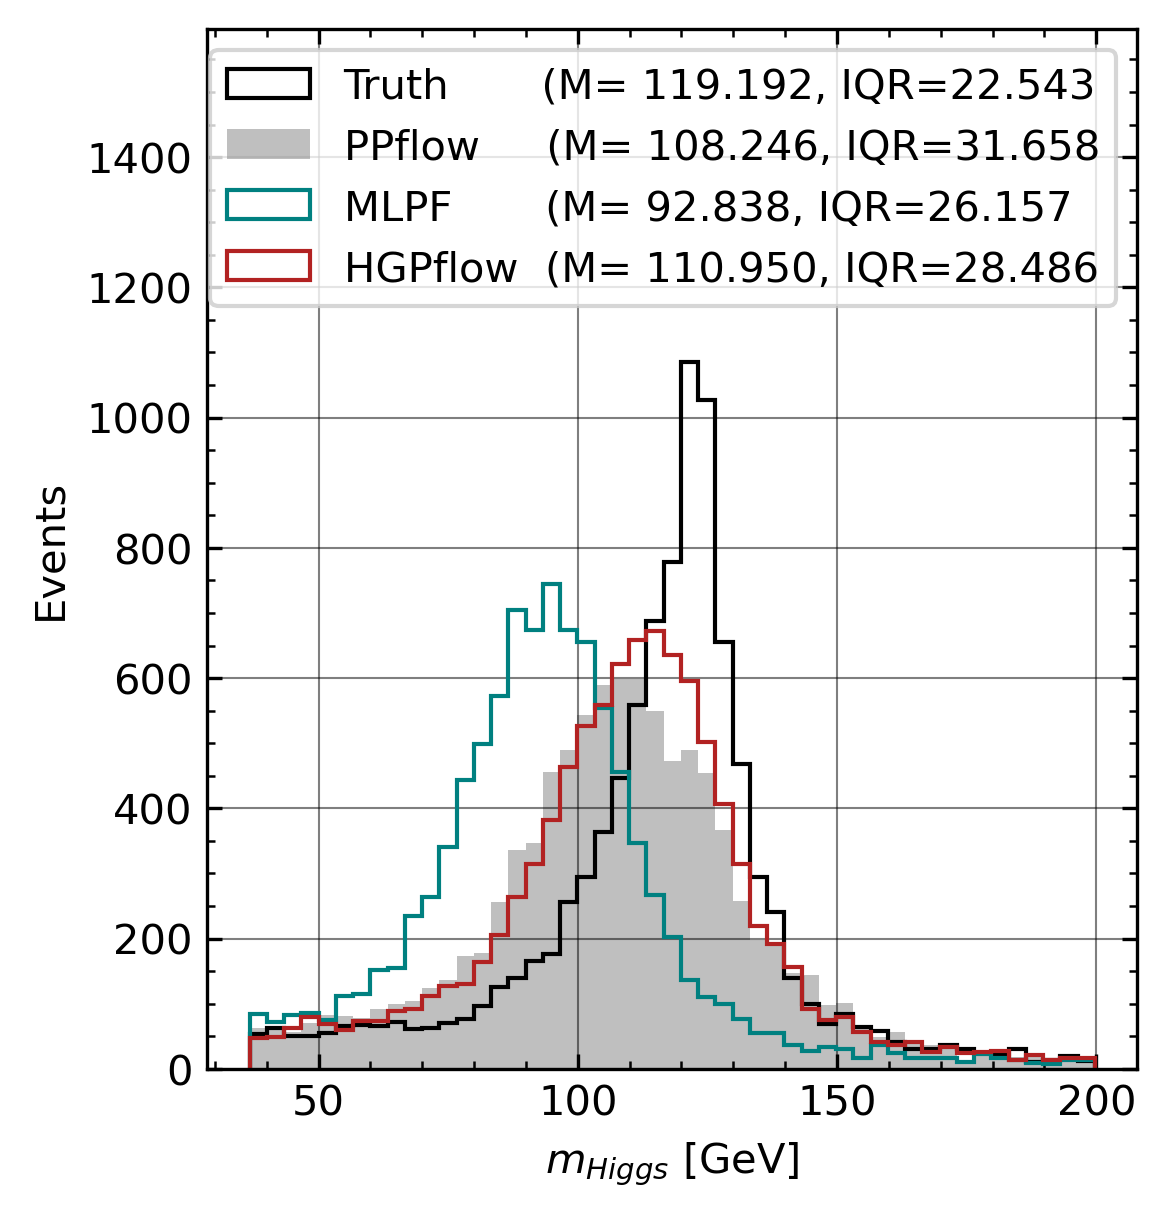

In [16]:
from hgpflow_v2.performance.plot_helper_event import plot_jet_inv_mass

jet_dict_zhbb_boosted = {
    'truth': perf_obj_zhbb_boosted.truth_dict['truth_jets'],
    'ppflow': perf_obj_zhbb_boosted.truth_dict['ppflow_jets'],
    'mlpf': perf_obj_zhbb_boosted.mlpf_dict['jets'],
    'hgpflow': perf_obj_zhbb_boosted.hgpflow_dict['jets']
}

fig = plot_jet_inv_mass(jet_dict_zhbb_boosted, leading_jet_option='one-jet', xlabel_flag='Higgs', stylesheet=style_sheet)
if SAVE_FIG:
    fig.savefig(f'{save_dir}/zhbb_boosted_jet_inv_mass.png', dpi=300)

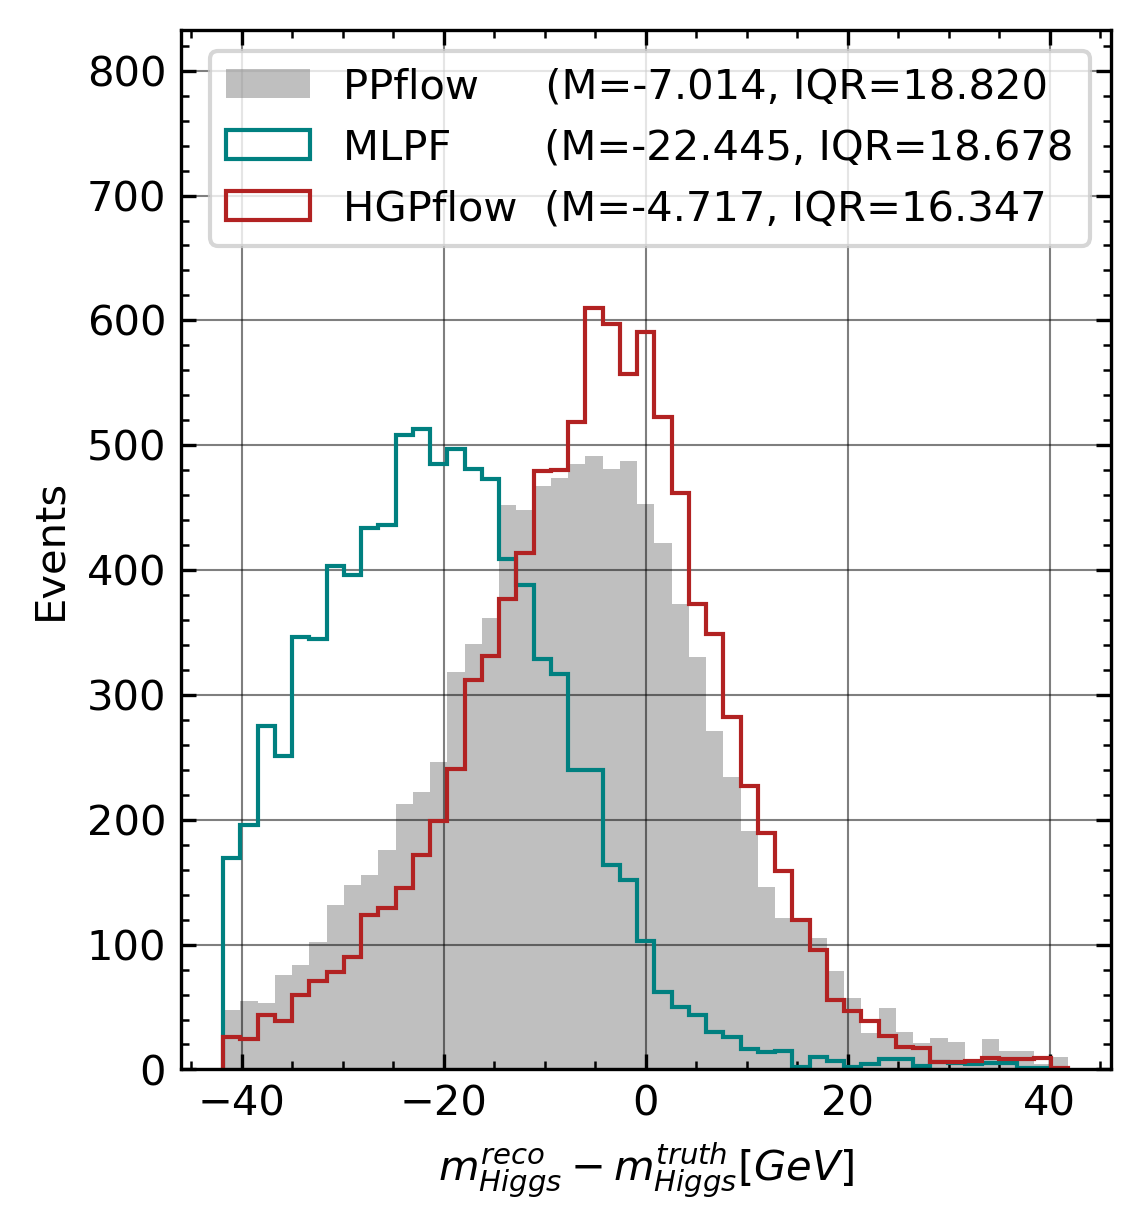

In [17]:
from hgpflow_v2.performance.plot_helper_event import plot_jet_inv_mass_residual

comp_jet_mass_res_dict_zhbb_boosted = {
    'ppflow': perf_obj_zhbb_boosted.truth_dict['ppflow_jets'],
    'mlpf': perf_obj_zhbb_boosted.mlpf_dict['jets'],
    'hgpflow': perf_obj_zhbb_boosted.hgpflow_dict['jets']
}
fig = plot_jet_inv_mass_residual(perf_obj_zhbb_boosted.truth_dict['truth_jets'], comp_jet_mass_res_dict_zhbb_boosted, leading_jet_option='one-jet', stylesheet=style_sheet, xlabel_flag='Higgs')
if SAVE_FIG:
    fig.savefig(f'{save_dir}/zhbb_boosted_jet_mass_res.png', dpi=300)

#### Jet residuals

In [ ]:
perf_obj_zhbb_boosted.match_jets()

In [9]:
from hgpflow_v2.performance.plot_helper_event import compute_jet_residual_dict

_dict_zhbb_boosted = {
    'ppflow': perf_obj_zhbb_boosted.truth_dict['matched_ppflow_jets'],
    'mlpf': perf_obj_zhbb_boosted.mlpf_dict['matched_mlpf_jets'],
    'hgpflow': perf_obj_zhbb_boosted.hgpflow_dict['matched_hgpflow_jets'],
}

# leading jet residual
jet_residual_dict_zhbb_boosted = compute_jet_residual_dict(_dict_zhbb_boosted, dr_cut=0.1, leading_N_jets=1, pt_min=10)

#### Jet residuals

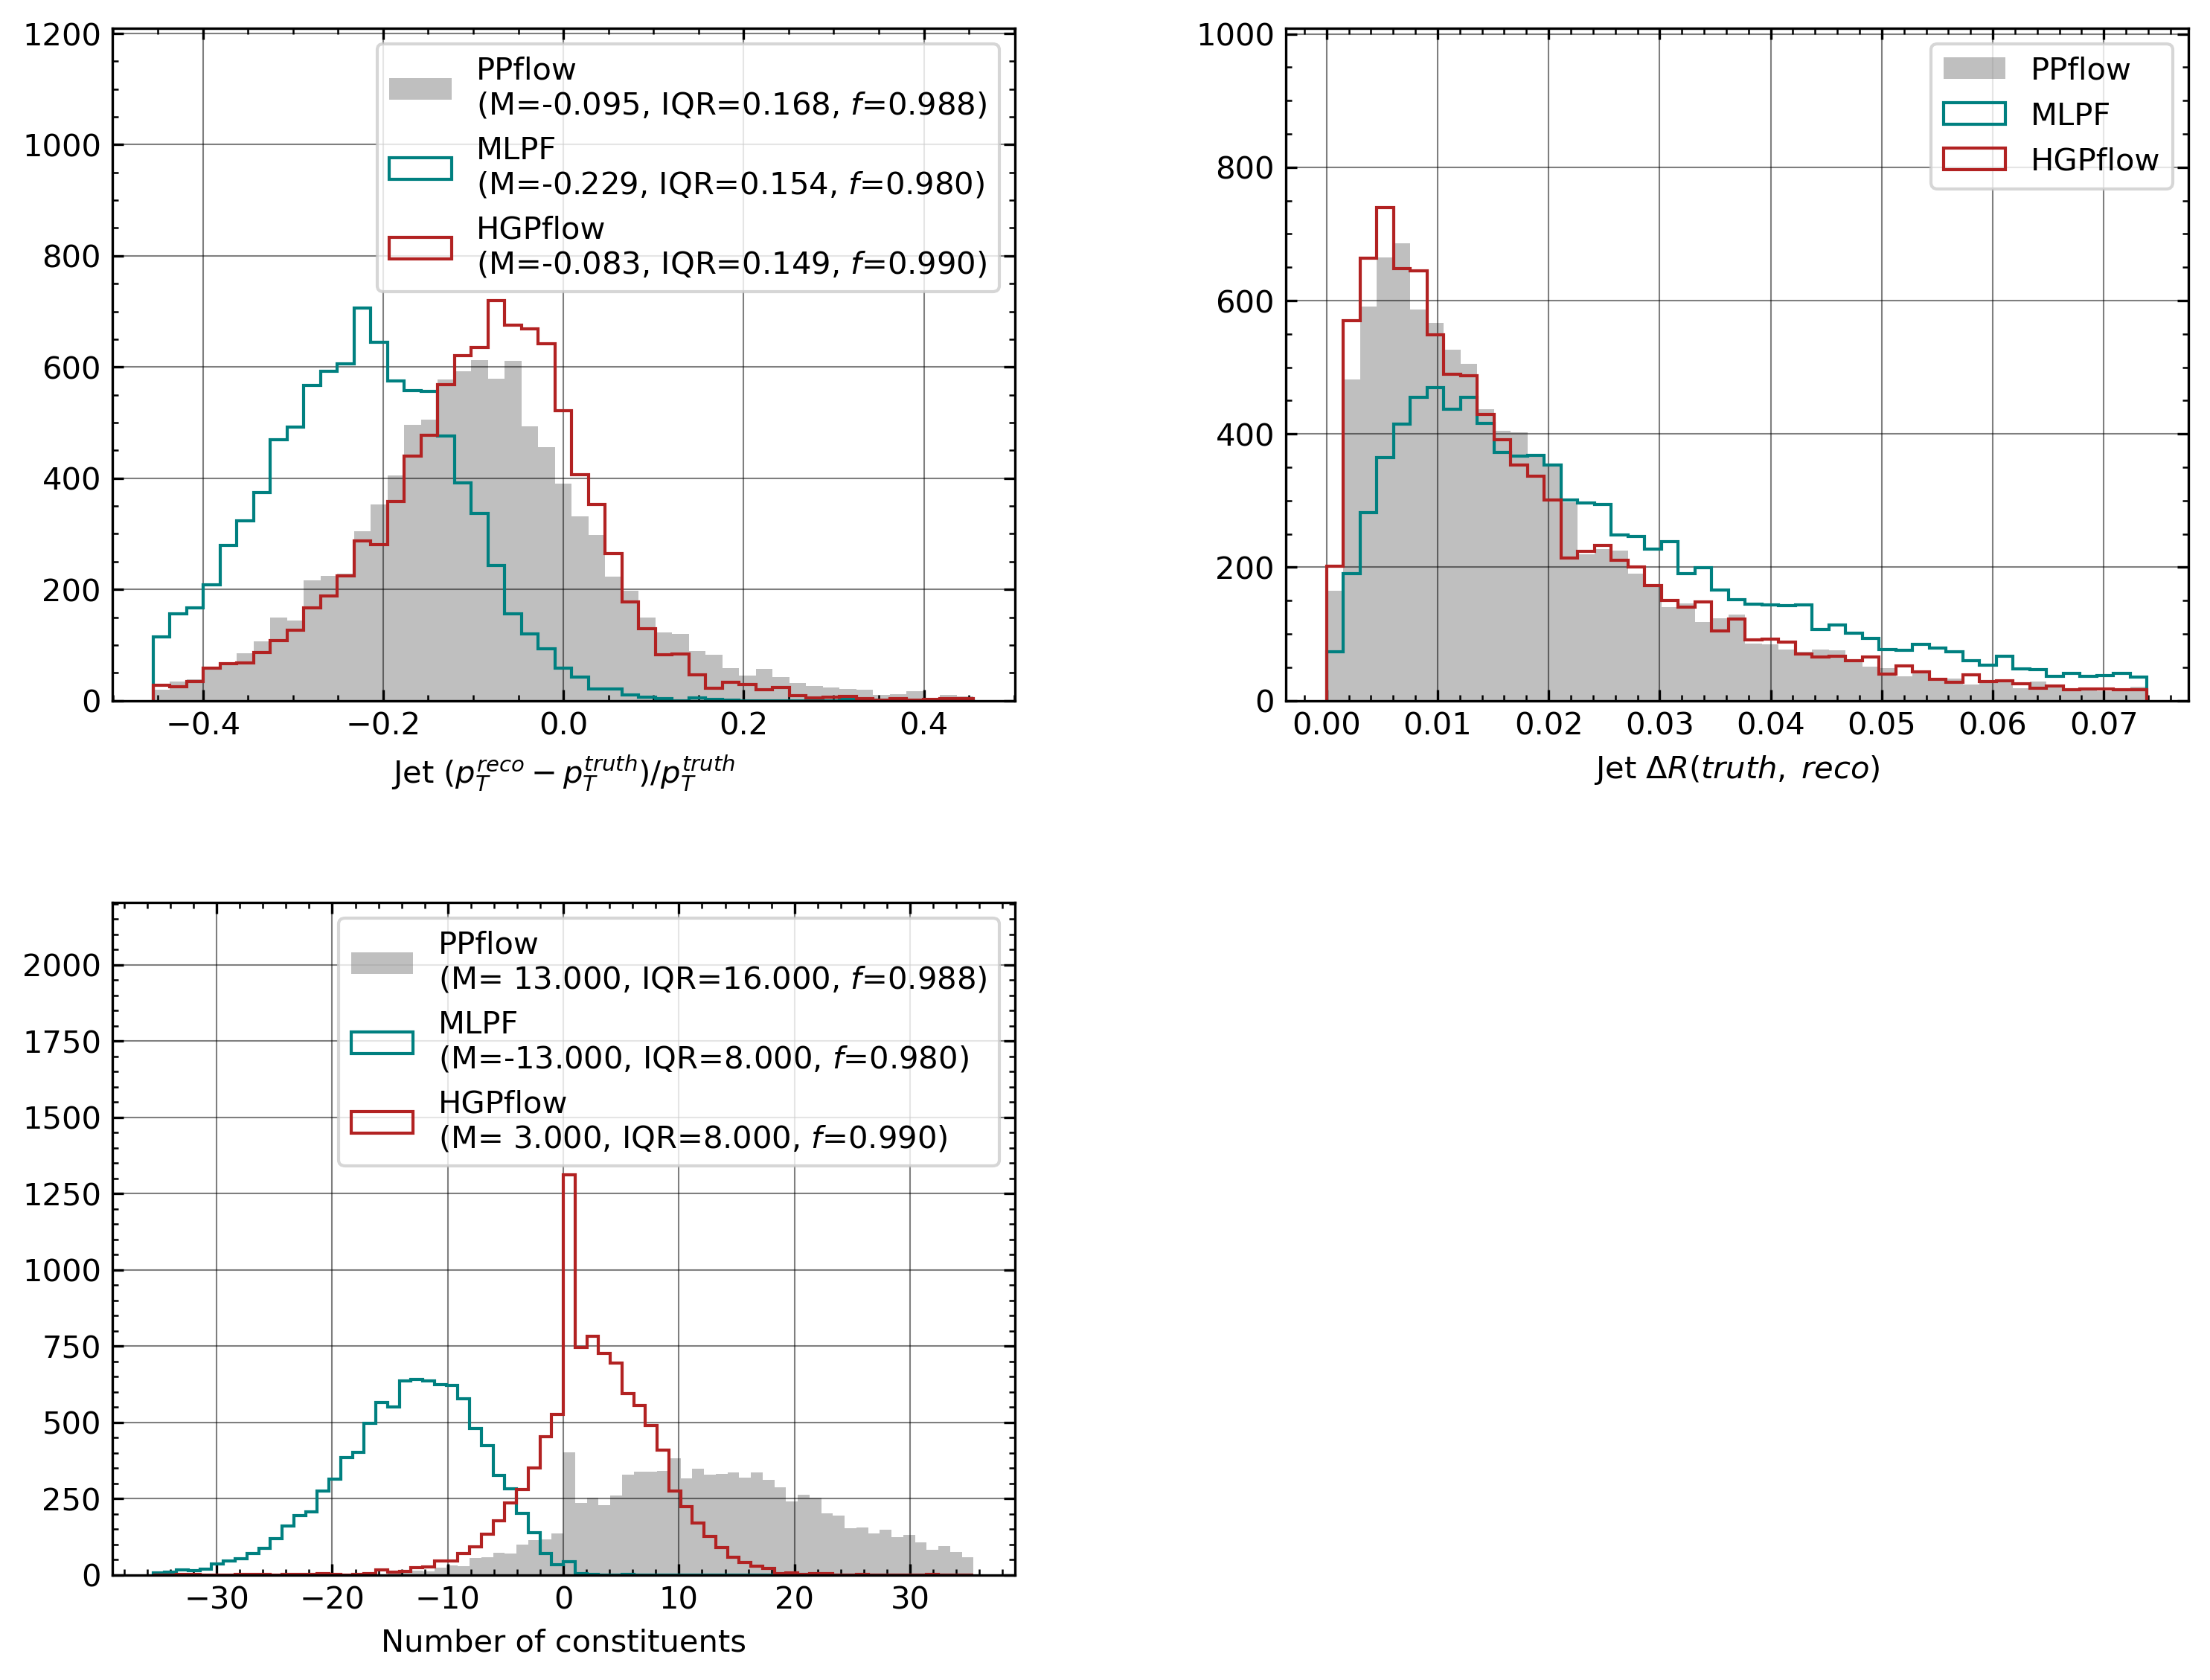

In [12]:
from hgpflow_v2.performance.plot_helper_event import plot_jet_residuals

figs = plot_jet_residuals(jet_residual_dict_zhbb_boosted, pt_relative=True, stylesheet=style_sheet, separate_figures=False)

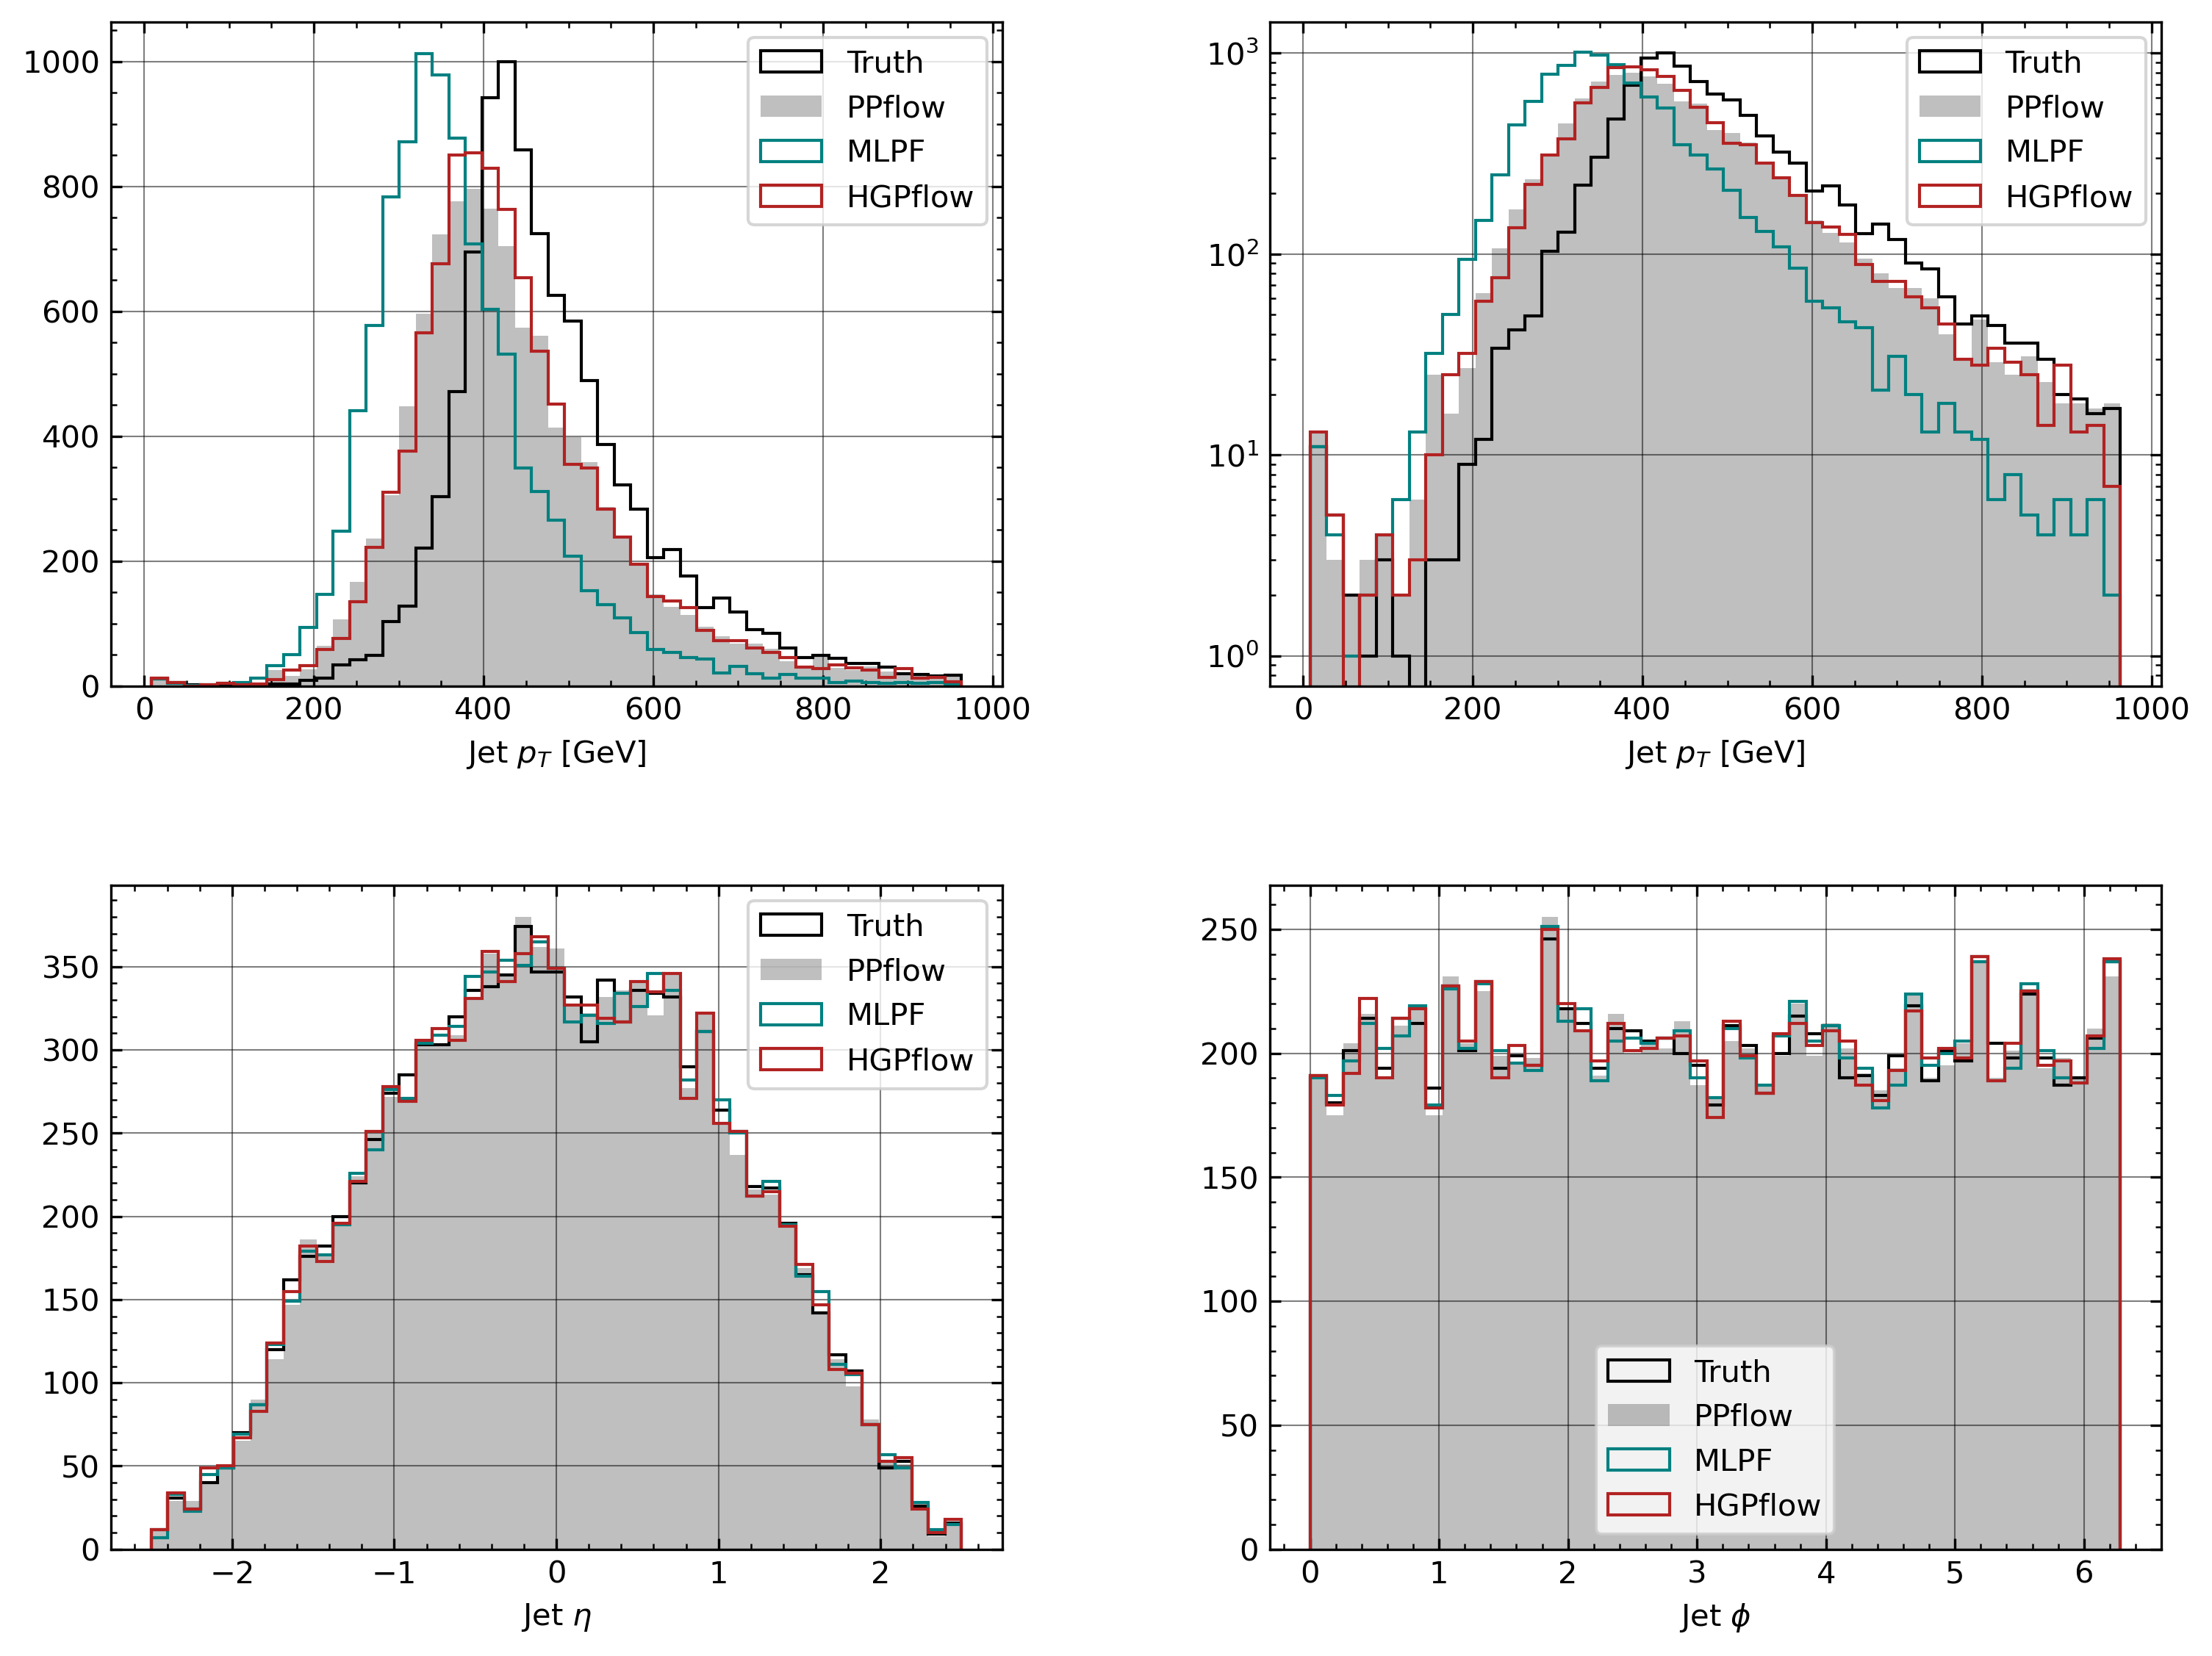

In [17]:
_jet_dict_zhbb_boosted = {
    'truth': perf_obj_zhbb_boosted.truth_dict['truth_jets'],
    'ppflow': perf_obj_zhbb_boosted.truth_dict['ppflow_jets'],
    'mlpf': perf_obj_zhbb_boosted.mlpf_dict['jets'],
    'hgpflow': perf_obj_zhbb_boosted.hgpflow_dict['jets'],
}

from hgpflow_v2.performance.plot_helper_event import plot_jet_marginals
fig = plot_jet_marginals(_jet_dict_zhbb_boosted, nleading=1, stylesheet=style_sheet)

#### Leading jet-substructure variables

In [18]:
from hgpflow_v2.performance.substructure_helper import compute_substructure_leading

n_procs = 30

print('Computing truth substructure...')
truth_substructure = compute_substructure_leading(
    perf_obj_zhbb_boosted.truth_dict['particle_pt'], perf_obj_zhbb_boosted.truth_dict['particle_eta'], perf_obj_zhbb_boosted.truth_dict['particle_phi'],
    perf_obj_zhbb_boosted.truth_dict['particle_mass'], 
    perf_obj_zhbb_boosted.truth_dict['truth_jets'], n_procs=n_procs, event_number=perf_obj_zhbb_boosted.truth_dict['event_number'])

print('Computing ppflow substructure...')
ppflow_substructure = compute_substructure_leading(
    perf_obj_zhbb_boosted.truth_dict['pflow_pt'], perf_obj_zhbb_boosted.truth_dict['pflow_eta'], perf_obj_zhbb_boosted.truth_dict['pflow_phi'],
    perf_obj_zhbb_boosted.truth_dict['pflow_mass'],
    perf_obj_zhbb_boosted.truth_dict['ppflow_jets'], n_procs=n_procs, event_number=perf_obj_zhbb_boosted.truth_dict['event_number'])

print('Computing hgpflow substructure...')
hgpflow_substructure = compute_substructure_leading(
    perf_obj_zhbb_boosted.hgpflow_dict['hgpflow_pt'], perf_obj_zhbb_boosted.hgpflow_dict['hgpflow_eta'], perf_obj_zhbb_boosted.hgpflow_dict['hgpflow_phi'],
    perf_obj_zhbb_boosted.hgpflow_dict['hgpflow_mass'],
    perf_obj_zhbb_boosted.hgpflow_dict['jets'], n_procs=n_procs, event_number=perf_obj_zhbb_boosted.hgpflow_dict['event_number'])

print('Computing mlpf substructure...')
mlpf_substructure = compute_substructure_leading(
    perf_obj_zhbb_boosted.mlpf_dict['pred_pt'], perf_obj_zhbb_boosted.mlpf_dict['pred_eta'], perf_obj_zhbb_boosted.mlpf_dict['pred_phi'],
    perf_obj_zhbb_boosted.mlpf_dict['pred_mass'],
    perf_obj_zhbb_boosted.mlpf_dict['jets'], n_procs=n_procs, event_number=perf_obj_zhbb_boosted.mlpf_dict['event_number'])

Computing truth substructure...
Computing ppflow substructure...
Computing hgpflow substructure...
Computing mlpf substructure...


In [19]:
style_sheet_substructure = {
    'COLORS': {
        'truth': 'black',
        'ppflow': 'gray',
        'hgpflow': 'firebrick',
        'mlpf': 'teal',
    },

    'ALPHAS': {
        'truth': 0.2,
        'ppflow': 1,
        'hgpflow': 1,
        'mlpf': 1,
    },

    'HISTTYPES': {
        'truth': 'stepfilled',
        'ppflow': 'step',
        'hgpflow': 'step',
        'mlpf': 'step',
    }
}

In [ ]:
from hgpflow_v2.performance.plot_helper_event import plot_leading_jet_substructure

common_events = np.intersect1d(truth_substructure[3], ppflow_substructure[3])
common_events = np.intersect1d(common_events, hgpflow_substructure[3])
common_events = np.intersect1d(common_events, mlpf_substructure[3])

# they are not ordered correctly. so, cannot compute residuals atm
truth_ev_idx = np.isin(truth_substructure[3], common_events)
ppflow_ev_idx = np.isin(ppflow_substructure[3], common_events)
hgpflow_ev_idx = np.isin(hgpflow_substructure[3], common_events)
mlpf_ev_idx = np.isin(mlpf_substructure[3], common_events)

substructure_dict = {
    'ppflow': [np.log(ppflow_substructure[0][ppflow_ev_idx]), ppflow_substructure[1][ppflow_ev_idx], ppflow_substructure[2][ppflow_ev_idx]],
    'mlpf': [np.log(mlpf_substructure[0][mlpf_ev_idx]), mlpf_substructure[1][mlpf_ev_idx], mlpf_substructure[2][mlpf_ev_idx]],
    'hgpflow': [np.log(hgpflow_substructure[0][hgpflow_ev_idx]), hgpflow_substructure[1][hgpflow_ev_idx], hgpflow_substructure[2][hgpflow_ev_idx]],
    'truth': [np.log(truth_substructure[0][truth_ev_idx]), truth_substructure[1][truth_ev_idx], truth_substructure[2][truth_ev_idx]],
}

figs = plot_leading_jet_substructure(substructure_dict, stylesheet=style_sheet, separate_figures=True)
if SAVE_FIG:
    figs[0].savefig(f'{save_dir}/zhbb_boosted_substructure_lnd2.png', dpi=300)
    figs[1].savefig(f'{save_dir}/zhbb_boosted_substructure_c2.png', dpi=300)
    figs[2].savefig(f'{save_dir}/zhbb_boosted_substructure_c3.png', dpi=300)